# Homework 2
# Parsa Daghigh

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Imports

In [2]:
! pip install tensorpac
import scipy.io as sio
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from scipy.stats import mode
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mutual_info_score
from itertools import combinations
from scipy.spatial.distance import squareform, pdist
from scipy.stats import kendalltau
import statsmodels.api as sm
from tensorpac import Pac
from scipy.signal import butter, filtfilt, hilbert, welch
from tqdm import tqdm
from scipy.stats import binned_statistic
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from scipy.stats import kendalltau


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 6.4 MB/s eta 0:00:00


## Spike sorting from scratch

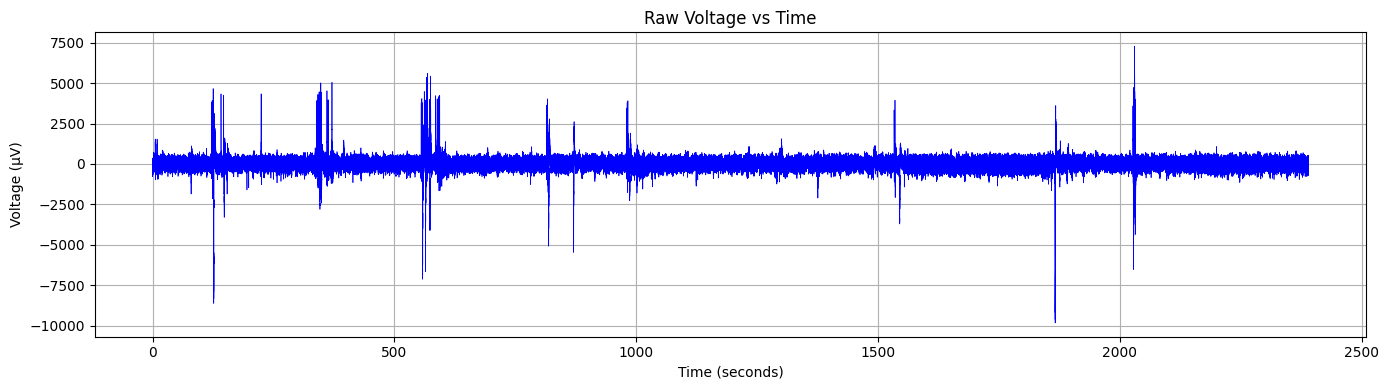

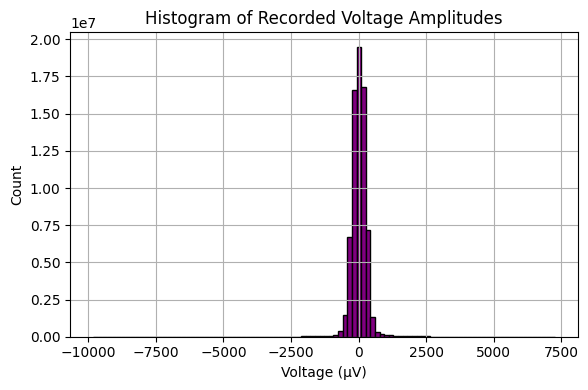

In [ ]:
file_path = '/content/drive/MyDrive/Cognitive_HW2/singleIT.mat'
with h5py.File(file_path, 'r') as f:

    signal = f['data_IT'][:]

signal = signal.flatten()

Fs = 30000
time = np.arange(signal.size) / Fs

# Plot 1: Voltage vs Time
plt.figure(figsize=(14, 4))
plt.plot(time, signal, color='blue', linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (µV)')
plt.title('Raw Voltage vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Histogram of Amplitudes
plt.figure(figsize=(6, 4))
plt.hist(signal, bins=100, color='purple', edgecolor='black')
plt.xlabel('Voltage (µV)')
plt.ylabel('Count')
plt.title('Histogram of Recorded Voltage Amplitudes')
plt.grid(True)
plt.tight_layout()
plt.show()

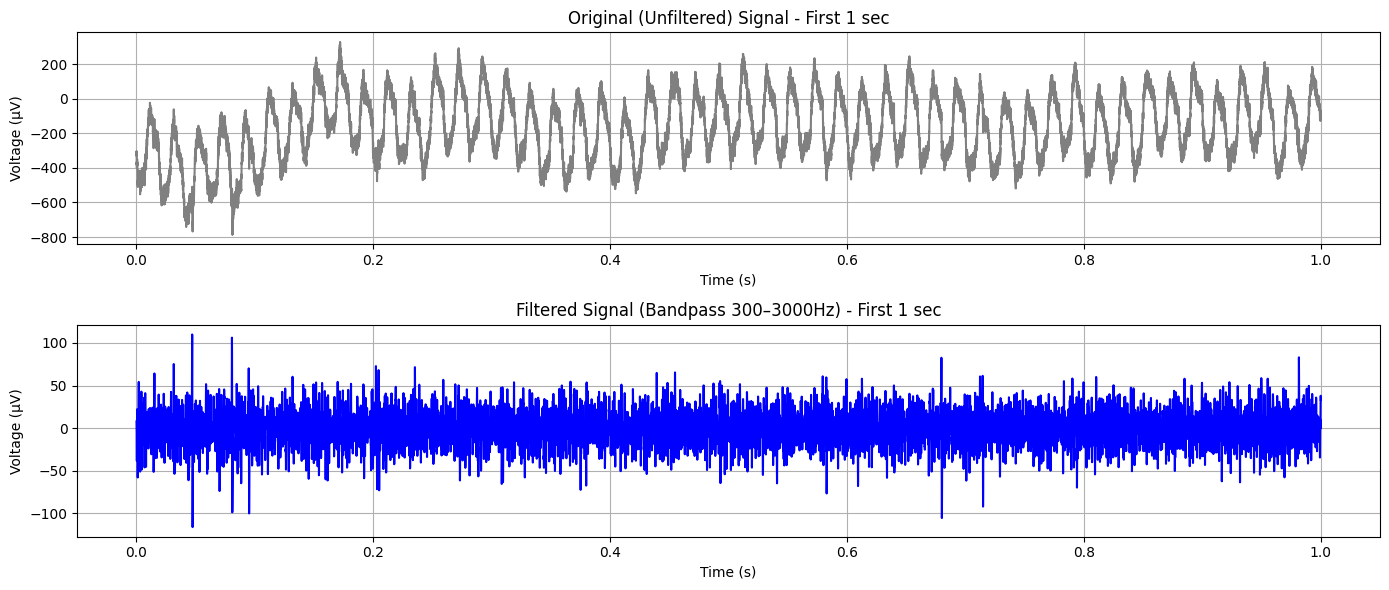

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

lowcut = 300
highcut = 3000
b, a = butter_bandpass(lowcut, highcut, Fs, order=3)
signal_filtered = filtfilt(b, a, signal)

# Plot original vs filtered
plt.figure(figsize=(14, 6))

plt.subplot(2,1,1)
plt.plot(time[:30000], signal[:30000], color='gray')
plt.title('Original (Unfiltered) Signal - First 1 sec')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time[:30000], signal_filtered[:30000], color='blue')
plt.title('Filtered Signal (Bandpass 300–3000Hz) - First 1 sec')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')
plt.grid(True)

plt.tight_layout()
plt.show()


Calculated threshold θ = 104.11 μV
Detected 29031 negative and 16405 positive peaks.
Total detected spikes: 45436
Extracted 45436 waveforms, each with 121 samples.


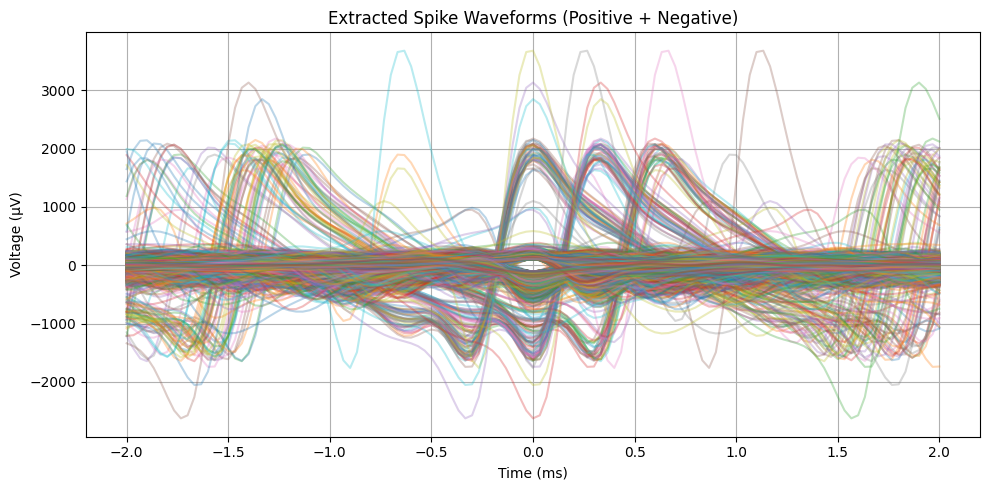

In [ ]:

# Calculate noise level (σ_n) and threshold θ
sigma_n = np.median(np.abs(signal_filtered)) / 0.6745
theta = 5 * sigma_n
print(f"Calculated threshold θ = {theta:.2f} μV")

# negative and positive spikes using threshold
neg_peaks, _ = find_peaks(-signal_filtered, height=theta)
pos_peaks, _ = find_peaks(signal_filtered, height=theta)

all_peaks = np.sort(np.concatenate((neg_peaks, pos_peaks)))
print(f"Detected {len(neg_peaks)} negative and {len(pos_peaks)} positive peaks.")
print(f"Total detected spikes: {len(all_peaks)}")

pre_samples = int(0.002 * Fs)
post_samples = int(0.002 * Fs)

valid_peaks = all_peaks[(all_peaks > pre_samples) & (all_peaks < len(signal_filtered) - post_samples)]

# spike waveforms
waveforms = []
for p in valid_peaks:
    wf = signal_filtered[p - pre_samples : p + post_samples + 1]
    waveforms.append(wf)
waveforms = np.array(waveforms)
print(f"Extracted {waveforms.shape[0]} waveforms, each with {waveforms.shape[1]} samples.")

plt.figure(figsize=(10, 5))
for wf in waveforms:
    plt.plot(np.linspace(-2, 2, waveforms.shape[1]), wf, alpha=0.3)
plt.title("Extracted Spike Waveforms (Positive + Negative)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.grid(True)
plt.tight_layout()
plt.show()

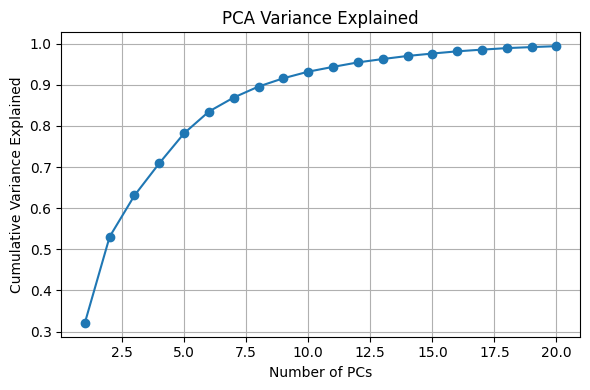

In [ ]:
pca = PCA()
pca.fit(waveforms)

scores = pca.transform(waveforms)

# Variance explained
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, 21), cum_explained[:20], marker='o')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
PC1 = scores[:, 0]
PC2 = scores[:, 1]
PC3 = scores[:, 2]

print(f"Variance explained by PC1–PC3: {cum_explained[2]*100:.1f}%")

Variance explained by PC1–PC3: 63.1%


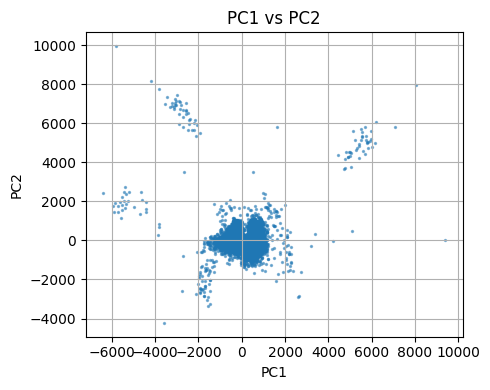

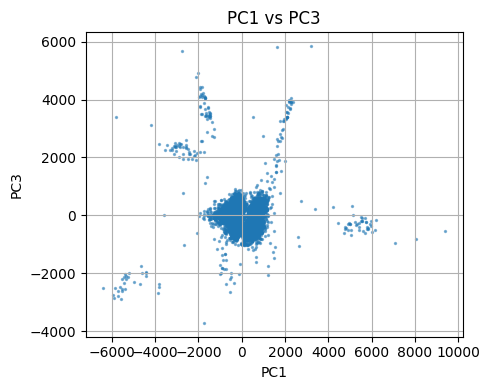

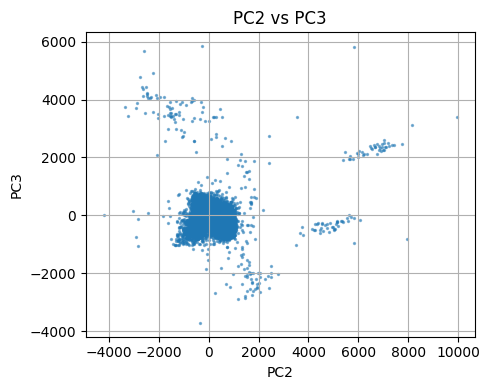

In [ ]:
# PC1 vs PC2
plt.figure(figsize=(5,4))
plt.scatter(PC1, PC2, s=2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2')
plt.grid(True)
plt.tight_layout()
plt.show()

# PC1 vs PC3
plt.figure(figsize=(5,4))
plt.scatter(PC1, PC3, s=2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('PC1 vs PC3')
plt.grid(True)
plt.tight_layout()
plt.show()

# PC2 vs PC3
plt.figure(figsize=(5,4))
plt.scatter(PC2, PC3, s=2, alpha=0.5)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PC2 vs PC3')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
n_pcs = 3
features = scores[:, :n_pcs]

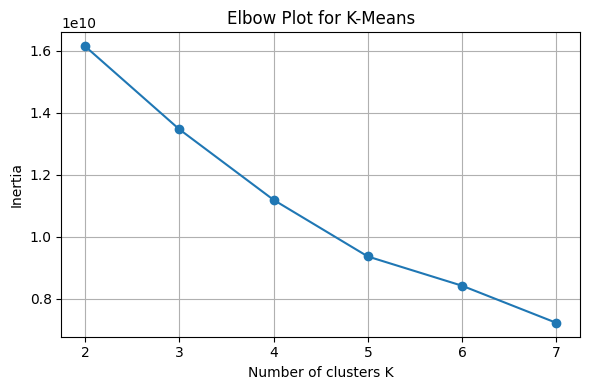

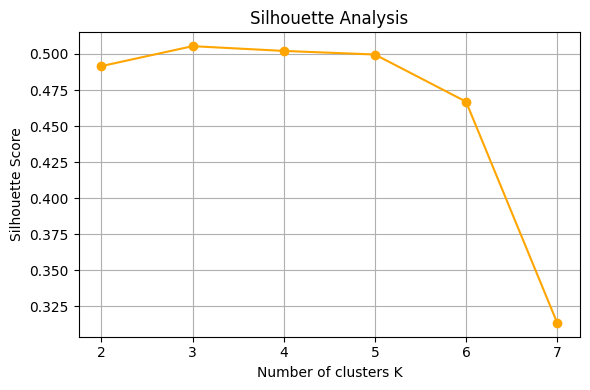

In [ ]:
inertias = []
silhouettes = []
K_range = range(2, 8)  # K = 2…7

for K in K_range:
    km = KMeans(n_clusters=K, random_state=0).fit(features)
    inertias.append(km.inertia_)
    sil = silhouette_score(features, km.labels_)
    silhouettes.append(sil)

# Elbow curve
plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means')
plt.grid(True)
plt.tight_layout()
plt.show()

# Silhouette scores
plt.figure(figsize=(6,4))
plt.plot(list(K_range), silhouettes, marker='o', color='orange')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
best_K = 3
km = KMeans(n_clusters=best_K, random_state=0).fit(features)
labels = km.labels_

print(f"Clustering done with K = {best_K}.")

Clustering done with K = 3.


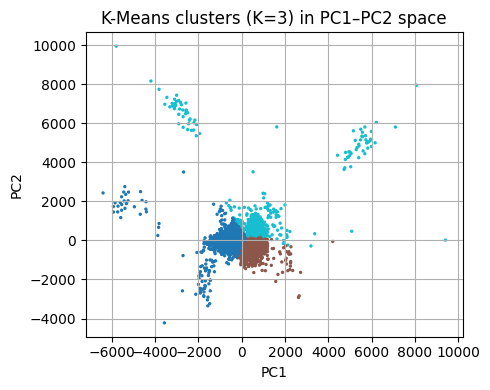

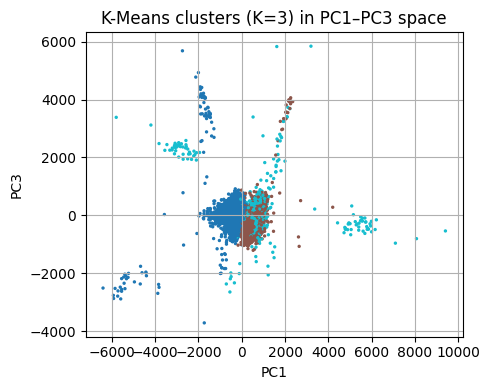

In [ ]:
# PC1 vs PC2
plt.figure(figsize=(5,4))
plt.scatter(features[:,0], features[:,1], c=labels, s=2, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-Means clusters (K={best_K}) in PC1–PC2 space')
plt.grid(True)
plt.tight_layout()
plt.show()

# PC1 vs PC3
plt.figure(figsize=(5,4))
plt.scatter(features[:,0], features[:,2], c=labels, s=2, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title(f'K-Means clusters (K={best_K}) in PC1–PC3 space')
plt.grid(True)
plt.tight_layout()
plt.show()

#### First threshold

In [ ]:
def get_spike_onsets(indices):
    """Returns the first sample of each continuous spike segment."""
    diffs = np.diff(indices)
    boundaries = np.where(diffs > 1)[0] + 1
    onsets = np.insert(indices[boundaries], 0, indices[0])
    return onsets


In [ ]:
scaling_factor = len(signal_filtered) / max(true_times)
true_times_rescaled = (true_times * 1000).astype(int)


In [ ]:
T = len(signal_filtered) / Fs   # in seconds
with h5py.File('/content/drive/MyDrive/Cognitive_HW2/Spikes.mat', 'r') as f:
    gt_down = np.array(f['ind_spikes_it']).flatten()
gt_time = np.linspace(0, T, len(gt_down))  # spread them over T seconds
gt_resampled = (gt_time * Fs).astype(int)


#### New threshold

New threshold θ_new = 154.71 µV
Detected 3 negative and 0 positive peaks.
Total spikes in [0–12000]: 3


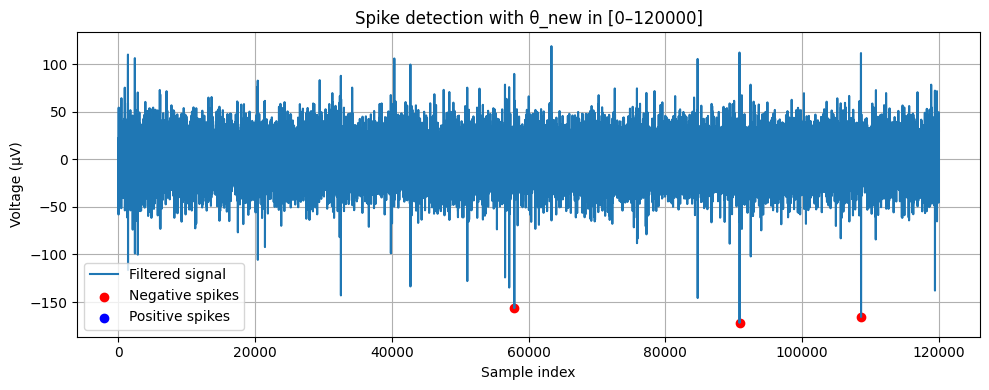

In [ ]:
eval_region = signal_filtered[:120000]

theta_new = 0.9 * np.max(np.abs(eval_region))
print(f"New threshold θ_new = {theta_new:.2f} µV")

neg_peaks, _ = find_peaks(-eval_region, height=theta_new)
pos_peaks, _ = find_peaks(eval_region, height=theta_new)

all_peaks = np.sort(np.concatenate([neg_peaks, pos_peaks]))
print(f"Detected {len(neg_peaks)} negative and {len(pos_peaks)} positive peaks.")
print(f"Total spikes in [0–12000]: {len(all_peaks)}")

plt.figure(figsize=(10, 4))
plt.plot(eval_region, label='Filtered signal')
plt.scatter(neg_peaks, eval_region[neg_peaks], color='red', label='Negative spikes')
plt.scatter(pos_peaks, eval_region[pos_peaks], color='blue', label='Positive spikes')
plt.title("Spike detection with θ_new in [0–120000]")
plt.xlabel("Sample index")
plt.ylabel("Voltage (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Calculated threshold θ = 58.05 µV (3 × σₙ)
Detected 119 negative and 89 positive peaks.
Total detected spikes: 208


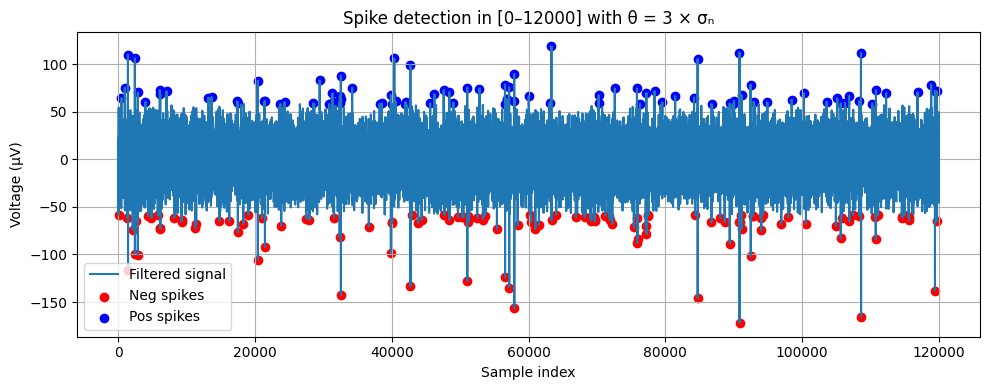

In [ ]:
eval_region = signal_filtered[:120000]

sigma_n = np.median(np.abs(eval_region)) / 0.6745
theta = 3 * sigma_n  # Use a lower multiplier than 5
print(f"Calculated threshold θ = {theta:.2f} µV (3 × σₙ)")

neg_peaks, _ = find_peaks(-eval_region, height=theta)
pos_peaks, _ = find_peaks(eval_region, height=theta)
all_peaks = np.sort(np.concatenate([neg_peaks, pos_peaks]))
print(f"Detected {len(neg_peaks)} negative and {len(pos_peaks)} positive peaks.")
print(f"Total detected spikes: {len(all_peaks)}")

plt.figure(figsize=(10, 4))
plt.plot(eval_region, label='Filtered signal')
plt.scatter(neg_peaks, eval_region[neg_peaks], color='red', label='Neg spikes')
plt.scatter(pos_peaks, eval_region[pos_peaks], color='blue', label='Pos spikes')
plt.title("Spike detection in [0–12000] with θ = 3 × σₙ")
plt.xlabel("Sample index")
plt.ylabel("Voltage (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Using tSNE instead of PCA

In [ ]:
max_spikes = 10000
idx = np.random.choice(len(waveforms), size=min(max_spikes, len(waveforms)), replace=False)
wave_sub = waveforms[idx]

tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=0, verbose=1)
features_tsne = tsne.fit_transform(wave_sub)  # shape: (n_samples, 3)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 1.519s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 104.894438
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.139793
[t-SNE] KL divergence after 1000 iterations: 1.614681


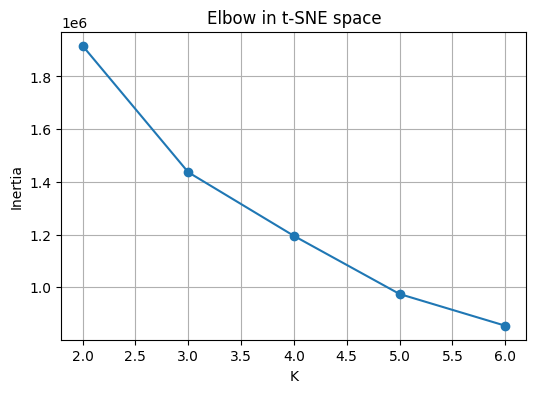

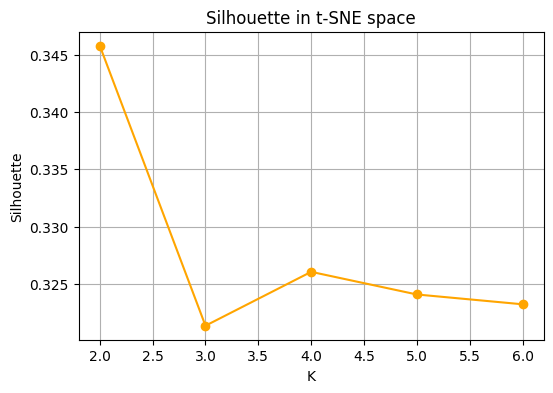

In [ ]:
Ks = range(2, 7)
inertias = []
sils = []

for K in Ks:
    km = KMeans(n_clusters=K, random_state=0).fit(features_tsne)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(features_tsne, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.title('Elbow in t-SNE space'); plt.xlabel('K'); plt.ylabel('Inertia'); plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(Ks, sils, marker='o', color='orange')
plt.title('Silhouette in t-SNE space'); plt.xlabel('K'); plt.ylabel('Silhouette'); plt.grid(True)
plt.show()

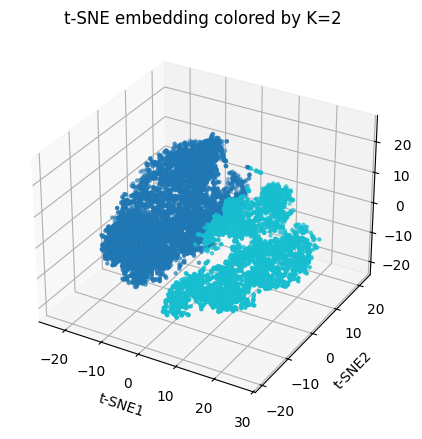

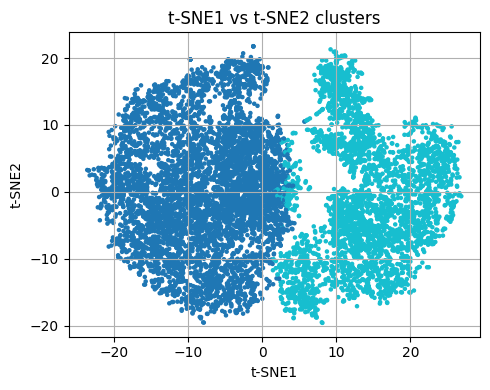

In [ ]:
best_K = 2
km = KMeans(n_clusters=best_K, random_state=0).fit(features_tsne)
labels_tsne = km.labels_

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(features_tsne[:,0], features_tsne[:,1], features_tsne[:,2],
                c=labels_tsne, s=5, cmap='tab10')
ax.set_xlabel('t-SNE1'); ax.set_ylabel('t-SNE2'); ax.set_zlabel('t-SNE3')
plt.title(f't-SNE embedding colored by K={best_K}')
plt.show()

# 2D pairwise
plt.figure(figsize=(5,4))
plt.scatter(features_tsne[:,0], features_tsne[:,1], c=labels_tsne, s=5, cmap='tab10')
plt.xlabel('t-SNE1'); plt.ylabel('t-SNE2')
plt.title('t-SNE1 vs t-SNE2 clusters')
plt.grid(True); plt.tight_layout(); plt.show()


## Analysis of Single Neuron Activity

### PSTH

In [ ]:
def dereference(data, file):
    """Dereferences HDF5 object references within the dataset."""
    return np.vectorize(lambda ref: read_matlab_file(file[ref], file), otypes=[object])(data)

def read_matlab_file(file_obj, file):
    """Recursively reads data from HDF5 file objects (Dataset or Group)."""
    if isinstance(file_obj, h5py.Dataset):
        data = file_obj[()].squeeze()
        if data.dtype == h5py.ref_dtype:
            data = dereference(data, file)
    elif isinstance(file_obj, h5py.Group):
        data = {}
        for subvar in file_obj.keys():
            data[subvar] = read_matlab_file(file_obj[subvar], file)
    else:
        # Return the file object itself if it's neither Dataset nor Group (e.g., a reference that couldn't be resolved)
        data = file_obj
    return data

try:
    with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as file:
        dataVasati = read_matlab_file(file['SpikeTrain_it_all'], file)
        data = dataVasati['data']
        cm = dataVasati['cm']
except FileNotFoundError:
    print("Error: 'dataVasati.mat' not found. Please ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the .mat file: {e}")
    exit()


data = np.vectorize(lambda arr: arr.T, otypes=[object])(data)


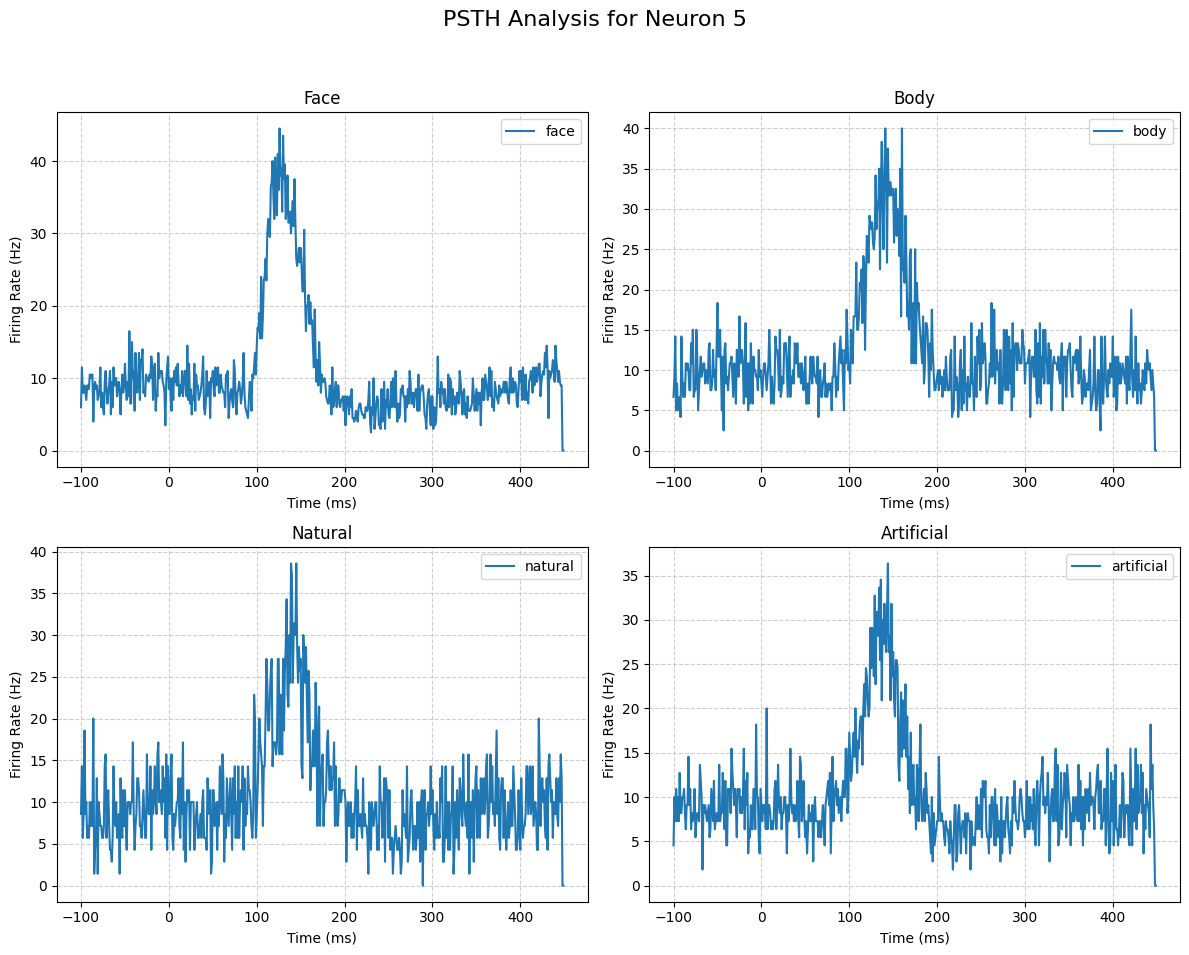

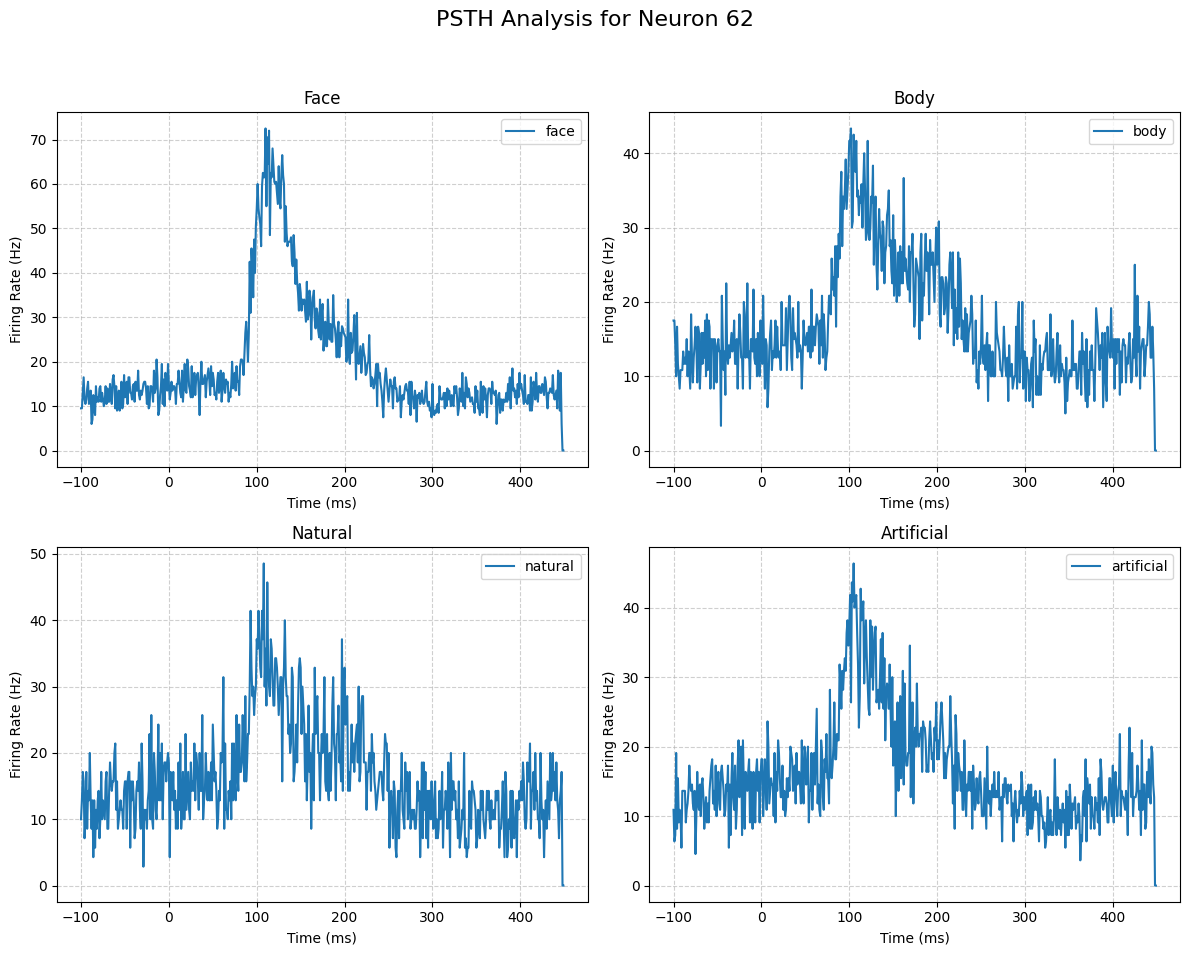

PSTH analysis complete. Plots saved as PDF files.


In [ ]:

sampling_rate = 1000 # Hz
n_neurons = data.size
n_trials = data[0].shape[0]
time_points = data[0].shape[1]
n_stimuli = 500
n_stimulus_trials = 10

categories = {
    "face": (1, 200),
    "body": (201, 320),
    "natural": (321, 390),
    "artificial": (391, 500)
}

bins = [0, 200, 320, 390, 500]

trial_categories = []
for neuron in range(n_neurons):
    trial_categories.append(pd.cut(cm[neuron]['index'].flatten(), bins=bins, labels=categories.keys(), include_lowest=True).to_numpy())

trial_categories = np.array(trial_categories, dtype=object)
for n, (neuron_data, neuron_cm) in enumerate(zip(data, cm)):
    grouped_trails = [[] for _ in range(n_stimuli)]
    for trial, stimulus_index in zip(neuron_data, neuron_cm['index'].flatten()):
        grouped_trails[stimulus_index.astype(int) - 1].append(trial)

    mean_stimulus_response = []
    for stimulus_trials in grouped_trails:
        if stimulus_trials:
            mean_stimulus_response.append(np.mean(np.array(stimulus_trials), axis=0) * sampling_rate)
        else:
            mean_stimulus_response.append(np.zeros(time_points))

    data[n] = np.array(mean_stimulus_response)

selected_neurons = [5, 62]

time_axis = np.arange(-100, -100 + time_points)

for neuron_idx_0based in [sn - 1 for sn in selected_neurons]:
    neuron_id = selected_neurons[selected_neurons.index(neuron_idx_0based + 1)]

    neuron_data = data[neuron_idx_0based]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    fig.suptitle(f'PSTH Analysis for Neuron {neuron_id}', fontsize=16)

    for i, (category, (start, end)) in enumerate(categories.items()):
        ax = axes[i]
        cat_stimulus_indices_0based = np.arange(start - 1, end)
        cat_stimulus_responses = neuron_data[cat_stimulus_indices_0based]

        if cat_stimulus_responses.size > 0:
            psth = np.mean(cat_stimulus_responses, axis=0)
            ax.plot(time_axis, psth, label=category)
        else:
            ax.plot(time_axis, np.zeros_like(time_axis), label=category + " (No data)")
            print(f"Warning: No data for category '{category}' for Neuron {neuron_id}")


        ax.set_title(f'{category.capitalize()}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Firing Rate (Hz)')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'psth_neuron_{neuron_id}_categories.pdf', bbox_inches='tight')
    plt.show() e


print("PSTH analysis complete. Plots saved as PDF files.")


In [ ]:
file_path    = '/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat'
neuron_index = 64

with h5py.File(file_path, 'r') as f:
    grp        = f['SpikeTrain_it_all']
    raster_ds  = grp['data']
    cm_ds      = grp['cm']

    raster_ref = raster_ds[neuron_index, 0]
    raster     = np.array(f[raster_ref])
    raster = raster.T
    print(f"Neuron {neuron_index} raster shape: {raster.shape}")

    cm_ref  = cm_ds[neuron_index, 0]
    idx_refs = f[cm_ref]['index'][:]
    cm = []
    for j in range(len(idx_refs)):
        ref = idx_refs[j][0] if isinstance(idx_refs[j], np.ndarray) else idx_refs[j]
        cm.append(int(f[ref][()]))
    cm = np.array(cm, dtype=int)

    print(f"Neuron {neuron_index} cm shape:    {cm.shape}")
    print("First 10 stimulus IDs:", cm[:10])


Neuron 64 raster shape: (5000, 550)


<ipython-input-5-191c8d937763>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm.append(int(f[ref][()]))


Neuron 64 cm shape:    (5000,)
First 10 stimulus IDs: [149  23 254 188 180 487 277 483 292 182]


<ipython-input-17-5a7d6215519a>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm.append(int(val[0]) if val.ndim > 0 else int(val))


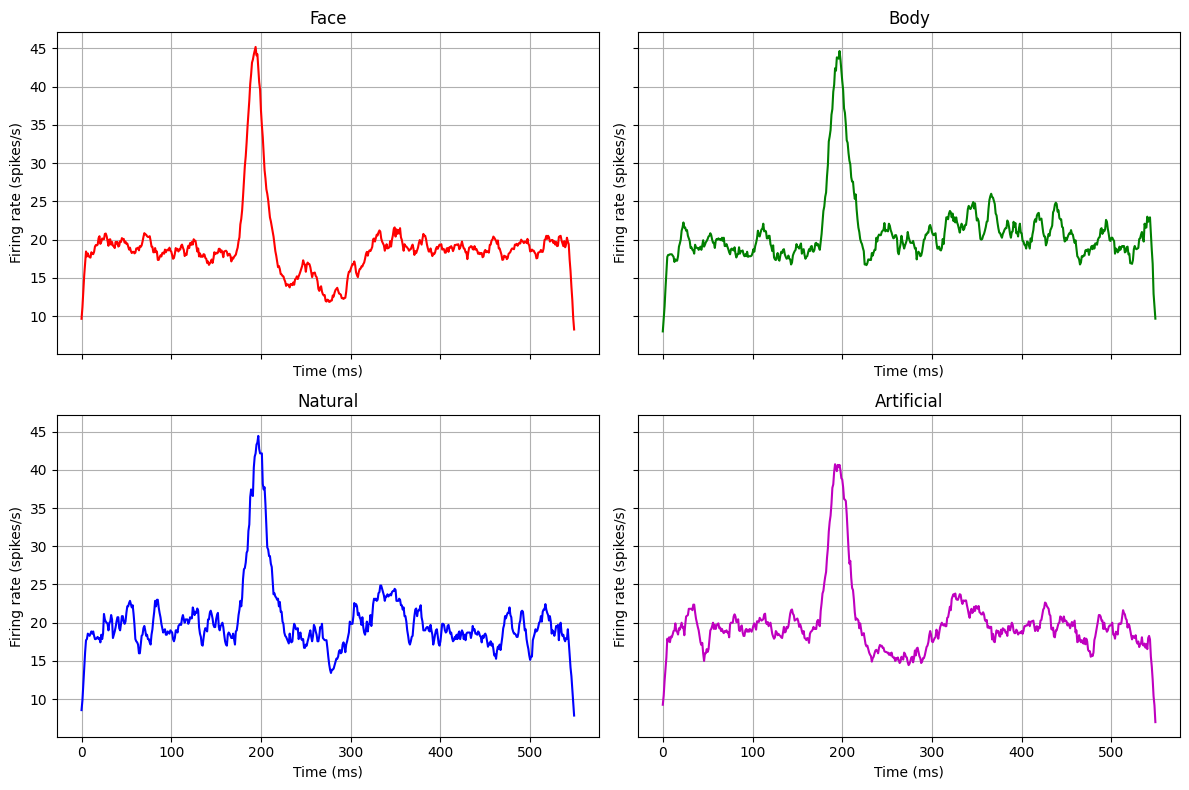

In [ ]:
file_path = '/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat'
neuron_index = 24

with h5py.File(file_path, 'r') as f:
    st_all    = f['SpikeTrain_it_all']
    raster_ds = st_all['data']
    cm_ds     = st_all['cm']

    # Load raster
    raster_ref = raster_ds[neuron_index, 0]
    raster0 = np.array(f[raster_ref])

    # Load stimulus IDs
    cm_ref = cm_ds[neuron_index, 0]
    idx_refs = f[cm_ref]['index'][:]
    cm = []
    for j in range(len(idx_refs)):
        ref = idx_refs[j][0] if isinstance(idx_refs[j], np.ndarray) else idx_refs[j]
        val = np.array(f[ref])  # safely convert to ndarray
        cm.append(int(val[0]) if val.ndim > 0 else int(val))
    cm = np.array(cm, dtype=int)
    if raster0.shape[0] != cm.shape[0]:
        if raster0.shape[1] == cm.shape[0]:
            raster0 = raster0.T
        else:
            raise ValueError(f"Shape mismatch: raster {raster0.shape} vs cm {cm.shape}")


category_map = np.full(cm.shape, -1)
category_map[(cm >= 1)   & (cm <= 200)] = 0  # Face
category_map[(cm >= 201) & (cm <= 320)] = 1  # Body
category_map[(cm >= 321) & (cm <= 390)] = 2  # Natural
category_map[(cm >= 391) & (cm <= 500)] = 3  # Artificial

n_timepoints = raster0.shape[1]
psth = {}
for cat in range(4):
    trials = raster0[category_map == cat, :]
    psth[cat] = trials.mean(axis=0) * 1000

time_ms = np.arange(n_timepoints)
categories = ['Face', 'Body', 'Natural', 'Artificial']
colors = ['r', 'g', 'b', 'm']

window = 10
kernel = np.ones(window) / window
psth_smooth = {cat: np.convolve(psth[cat], kernel, mode='same') for cat in psth}

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for ax, cat in zip(axes.flatten(), psth_smooth):
    ax.plot(time_ms, psth_smooth[cat], color=colors[cat], linewidth=1.5)
    ax.set_title(categories[cat])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing rate (spikes/s)')
    ax.grid(True)

plt.tight_layout()
plt.show()


Neuron 24 raster shape: (550, 5000)
Neuron 24 cm/index shape: (5000,)
First 10 picture indices: ['<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>']


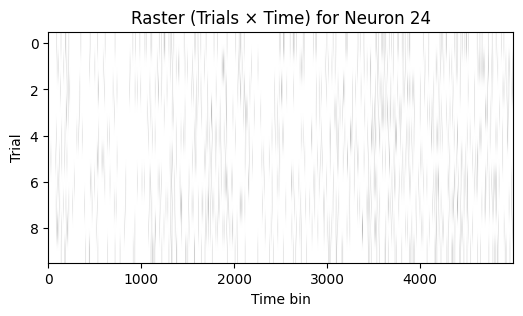

In [ ]:
file_path = '/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat'
neuron_index = 24

with h5py.File(file_path, 'r') as f:
    st_all    = f['SpikeTrain_it_all']
    raster_ds = st_all['data']
    cm_ds     = st_all['cm']

    raster_ref = raster_ds[neuron_index, 0]
    raster0    = np.array(f[raster_ref])
    print(f"Neuron {neuron_index} raster shape:", raster0.shape)

    cm_ref    = cm_ds[neuron_index, 0]
    cm_group  = f[cm_ref]
    cm_index  = np.array(cm_group['index']).squeeze().astype(str)
    print(f"Neuron {neuron_index} cm/index shape:", cm_index.shape)
    print("First 10 picture indices:", cm_index[:10])

    # Raster plot
    plt.figure(figsize=(6,3))
    plt.imshow(raster0[:10, :], aspect='auto', cmap='gray_r')
    plt.title(f'Raster (Trials × Time) for Neuron {neuron_index}')
    plt.xlabel('Time bin')
    plt.ylabel('Trial')
    plt.show()


Raster shape (trials × time): (5000, 550)


<ipython-input-19-3da0fe216dc3>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pic_nums.append(int(value))


Picture indices shape: (5000,)
First 10 picture indices: [383 390 176 301  91 252 314 310 401 196]


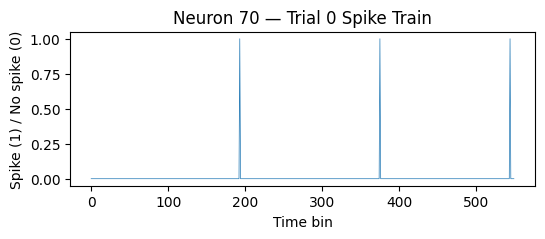

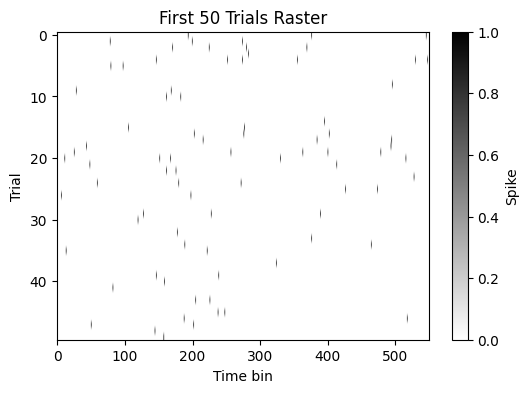

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


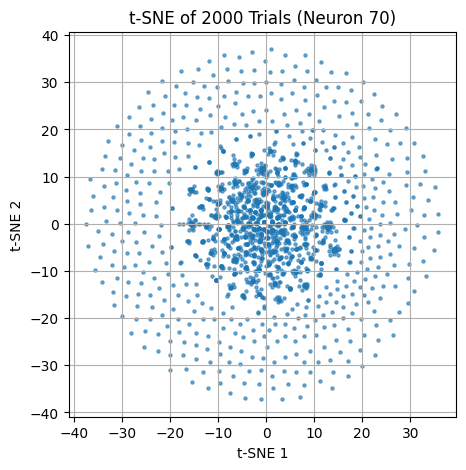

In [ ]:
neuron_index = 24
with h5py.File(file_path, 'r') as f:
    st_all     = f['SpikeTrain_it_all']
    raster_ref = st_all['data'][neuron_index, 0]
    cm_ref     = st_all['cm']  [neuron_index, 0]


    raw       = np.array(f[raster_ref])
    raster0   = raw.T
    print("Raster shape (trials × time):", raster0.shape)

    # Dereference cm/index properly
    idx_dataset = f[cm_ref]['index']
    idx_refs    = idx_dataset[()]
    idx_refs    = idx_refs.flatten()
    pic_nums = []
    for ref in idx_refs:
        value = f[ref][()]
        pic_nums.append(int(value))
    pic_nums = np.array(pic_nums)
    print("Picture indices shape:", pic_nums.shape)
    print("First 10 picture indices:", pic_nums[:10])


    plt.figure(figsize=(6,2))
    plt.plot(raster0[0], lw=0.5)
    plt.title(f"Neuron {neuron_index} — Trial 0 Spike Train")
    plt.xlabel("Time bin")
    plt.ylabel("Spike (1) / No spike (0)")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.imshow(raster0[:50], aspect='auto', cmap='gray_r')
    plt.title("First 50 Trials Raster")
    plt.xlabel("Time bin")
    plt.ylabel("Trial")
    plt.colorbar(label="Spike")
    plt.show()

    subsamp = min(2000, raster0.shape[0])
    sel     = np.random.choice(raster0.shape[0], subsamp, replace=False)
    X       = raster0[sel]  # shape (subsamp, 550)

    tsne = TSNE(n_components=2, perplexity=30, random_state=0, n_iter=500, verbose=0)
    X2   = tsne.fit_transform(X)

    plt.figure(figsize=(5,5))
    plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.6)
    plt.title(f"t-SNE of {subsamp} Trials (Neuron {neuron_index})")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()


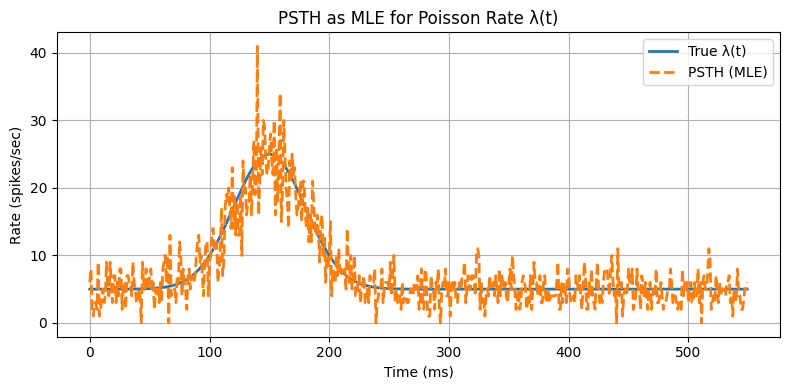

In [ ]:
n_trials = 1000
n_time   = 550
t = np.arange(n_time)
lambda_t = 5 + 20 * np.exp(-0.5 * ((t - 150) / 30)**2)

lambda_ms = lambda_t / 1000.0

spike_trains = np.random.poisson(lambda_ms[None, :], size=(n_trials, n_time))

psth = spike_trains.mean(axis=0) * 1000.0
lambda_mle = psth

# 4) true λ(t) vs. PSTH (MLE)
plt.figure(figsize=(8,4))
plt.plot(t, lambda_t,  label='True λ(t)', linewidth=2)
plt.plot(t, lambda_mle, '--', label='PSTH (MLE)', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Rate (spikes/sec)')
plt.title('PSTH as MLE for Poisson Rate λ(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Fano Factor

In [ ]:

def category_based_fano(raster_all, cm_all, StmLabels,
                        window_length=50, sliding_step=5):
    """
    Compute mean and variance of spike counts in sliding windows,
    separately for each category and each neuron.

    raster_all: list or array of shape (n_neurons,) where each element is (n_trials, n_time)
    cm_all:     list/array of shape (n_neurons,) where each element is (n_trials,) picture IDs
    StmLabels:  array mapping picture ID -> category (0–3)
    window_length: window size in bins (e.g. 200 for 100–300 ms)
    sliding_step:  step size in bins (e.g. 50 for 50 ms sliding)

    Returns:
      mean_vec: dict[cat] → array (n_neurons, n_time_slices)
      var_vec:  dict[cat] → array (n_neurons, n_time_slices)
      counts_dict: dict[cat] → list of per-neuron count arrays [(n_trials_cat, n_slices), …]
    """
    n_neurons = len(raster_all)
    n_time    = raster_all[0].shape[1]
    # number of sliding windows:
    n_slices = 1 + (n_time - window_length) // sliding_step

    mean_vec = {cat: np.zeros((n_neurons, n_slices)) for cat in range(4)}
    var_vec  = {cat: np.zeros((n_neurons, n_slices)) for cat in range(4)}
    counts_dict = {cat: [None]*n_neurons for cat in range(4)}

    for i in range(n_neurons):
        raster = raster_all[i]
        pics   = cm_all[i]
        cats   = StmLabels[pics]

        for cat in range(4):
            sel = np.where(cats == cat)[0]
            data = raster[sel]

            counts = np.zeros((data.shape[0], n_slices))

            for u in range(n_slices):
                start = sliding_step * u
                end   = start + window_length
                counts[:, u] = data[:, start:end].sum(axis=1)

            counts_dict[cat][i] = counts
            mean_vec[cat][i] = counts.mean(axis=0)
            var_vec [cat][i] = counts.var (axis=0)

    return mean_vec, var_vec, counts_dict


In [ ]:

def compute_mmff(psth_tensor, StmLabels, n_bins=8):
    """
    Compute Mean-Matched Fano Factor (MMFF) across time and category.

    Parameters:
    - psth_tensor: (n_neurons, n_stimuli, n_slices)
    - StmLabels:  (n_stimuli + 1,) category label for each picture ID
    - n_bins:     Number of bins to match mean rates across categories

    Returns:
    - fano_avg:   dict[cat] = mean-matched FF (1D array of length n_slices)
    """
    n_neurons, n_stimuli, n_slices = psth_tensor.shape
    fano_avg = {}

    for cat in range(4):
        ff_all = []
        for t in range(n_slices):
            means, variances = [], []

            for n in range(n_neurons):
                spike_counts = psth_tensor[n, :, t]
                labels = StmLabels[1:]
                stim_cat = labels == cat

                counts_cat = spike_counts[stim_cat]

                mean_cat = np.mean(counts_cat)
                var_cat  = np.var(counts_cat)
                means.append(mean_cat)
                variances.append(var_cat)

            means = np.array(means)
            variances = np.array(variances)

            valid = means > 0
            ff = variances[valid] / means[valid]

            print("Sample means:", means[:5])
            print("Sample vars:", variances[:5])
            print("FFs:", ff[:5])
            if len(ff) > 0:
                ff_all.append(np.mean(ff))
            else:
                ff_all.append(np.nan)

        fano_avg[cat] = np.array(ff_all)

    return fano_avg

def plot_fano(fano_avg, time_start=0, time_step=5):
    """
    Plot MMFF over time for 4 categories.

    Parameters:
    - fano_avg: dict from compute_mmff()
    - time_start: time of first slice (e.g. 0 ms)
    - time_step:  time between slices (e.g. 5 ms)
    """
    times = np.arange(len(fano_avg[0])) * time_step + time_start

    plt.figure(figsize=(10, 5))
    colors = ['red', 'orange', 'green', 'blue']
    labels = ['Face', 'Body', 'Natural', 'Artificial']

    for cat in range(4):
        ff = fano_avg[cat]
        smoothed = np.convolve(ff, np.ones(5)/5, mode='same')
        plt.plot(times, smoothed, color=colors[cat], label=labels[cat])

    plt.axhline(1.0, linestyle='--', color='gray', label='Poisson baseline')
    plt.xlabel("Time (ms)")
    plt.ylabel("Mean-Matched Fano Factor")
    plt.title("MMFF Across Time by Category")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [ ]:
with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as f:
    st = f['SpikeTrain_it_all']
    data_ds = st['data']
    cm_ds   = st['cm']
    raster_all = []
    cm_all     = []
    for i in range(92):
        rref = data_ds[i, 0]
        cref = cm_ds[i, 0]
        raster = np.array(f[rref])
        cm     = np.array(f[cref]['index'][:]).flatten().astype(str)

        raster_all.append(raster.T)
        cm_all.append(cm)


print("Loaded raster_all list length:", len(raster_all))
print("Example neuron 0 raster shape:", raster_all[0].shape)
print("Loaded cm_all list length:",   len(cm_all))
print("Example neuron 0 cm shape:",   cm_all[0].shape)


Loaded raster_all list length: 92
Example neuron 0 raster shape: (5000, 550)
Loaded cm_all list length: 92
Example neuron 0 cm shape: (5000,)


In [ ]:
def load_raster_cm(mat_path):
    """
    Load raw raster and cm from HDF5 SpikeTrain_it_all group.
    Returns:
      raster_all: list of arrays, each (n_trials, n_time)
      cm_all:     list of arrays, each (n_trials,) with stimulus IDs
    """
    raster_all = []
    cm_all     = []
    with h5py.File(mat_path, 'r') as f:
        st = f['SpikeTrain_it_all']
        data_ds = st['data']
        cm_ds   = st['cm']
        for i in range(data_ds.shape[0]):
            rref = data_ds[i, 0]
            raw = np.array(f[rref])
            raster_all.append(raw.T)
            cref = cm_ds[i, 0]
            cm_grp = f[cref]
            idx_refs = cm_grp['index'][:]
            cm = np.zeros(idx_refs.shape[0], dtype=int)
            for j, ref in enumerate(idx_refs):
                if isinstance(ref, np.ndarray):
                    ref = ref[0]
                cm[j] = int(f[ref][()])
            cm_all.append(cm)
    return raster_all, cm_all

def build_psth_tensor(raster_all, cm_all, win_len=50, step=5):
    n_neurons = len(raster_all)
    trial_stim = cm_all[0]
    stim_ids = np.unique(trial_stim).astype(int)
    n_slices = 1 + (raster_all[0].shape[1] - win_len) // step
    psth_tensor = np.zeros((n_neurons, len(stim_ids), n_slices))
    for ni in range(n_neurons):
        raster = raster_all[ni]
        for si, sid in enumerate(stim_ids):
            trials = np.where(trial_stim == sid)[0]
            avg_psth = raster[trials].mean(axis=0)
            for s in range(n_slices):
                start = s * step
                psth_tensor[ni, si, s] = avg_psth[start:start+win_len].sum()
    return psth_tensor, stim_ids

def build_StmLabels(stim_ids):
    max_id = int(np.max(stim_ids))
    StmLabels = np.zeros(max_id+1, dtype=int)
    StmLabels[1:201]   = 0  # Face
    StmLabels[201:321] = 1  # Body
    StmLabels[321:391] = 2  # Natural
    StmLabels[391:501] = 3  # Artificial
    return StmLabels

def compute_mmff(psth_tensor, StmLabels):
    n_neurons, n_stimuli, n_slices = psth_tensor.shape
    fano_avg = {}
    labels = StmLabels[1:]
    for cat in range(4):
        ff_all = []
        for t in range(n_slices):
            ff_cat = []
            for n in range(n_neurons):
                counts = psth_tensor[n, :, t]
                cat_idx = labels == cat
                m = counts[cat_idx].mean()
                v = counts[cat_idx].var()
                if m > 0:
                    ff_cat.append(v/m)
            ff_all.append(np.nanmean(ff_cat) if ff_cat else np.nan)
        fano_avg[cat] = np.array(ff_all)
    return fano_avg

def plot_fano(fano_avg, time_start=0, time_step=5):
    n_slices = len(next(iter(fano_avg.values())))
    times = np.arange(n_slices) * time_step + time_start
    plt.figure(figsize=(10, 5))
    colors = ['red','orange','green','blue']
    names = ['Face','Body','Natural','Artificial']
    for cat in range(4):
        sm = np.convolve(fano_avg[cat], np.ones(5)/5, mode='same')
        plt.plot(times, sm, label=names[cat], color=colors[cat], linewidth=2)
    plt.axhline(1, linestyle='--', color='gray', label='Poisson baseline')
    plt.xlabel('Time (ms)')
    plt.ylabel('Mean-Matched Fano Factor')
    plt.title('MMFF Across Time by Category')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


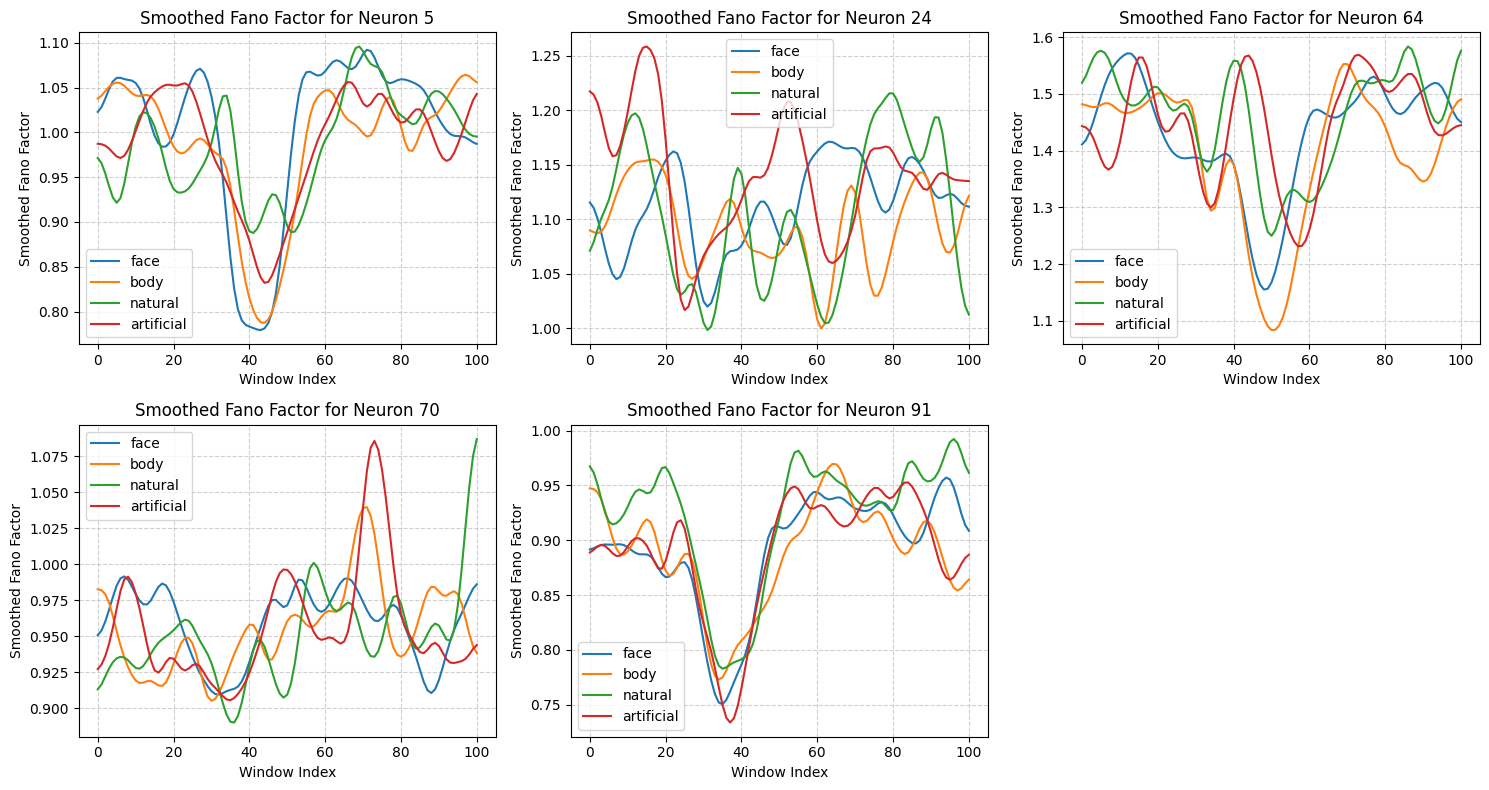

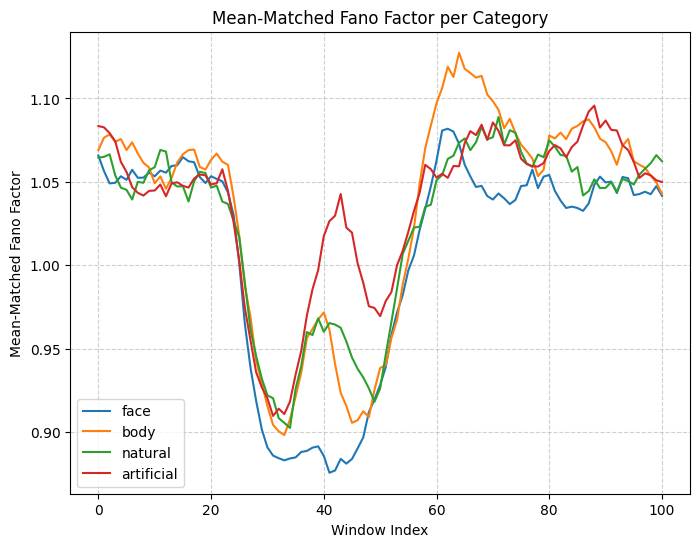

Fano Factor and Mean-Matched Fano Factor analysis complete. Plots saved as PDF files.


In [ ]:
def dereference(data, file):
    return np.vectorize(lambda ref: read_matlab_file(file[ref], file), otypes=[object])(data)

def read_matlab_file(file_obj, file):
    if isinstance(file_obj, h5py.Dataset):
        data = file_obj[()].squeeze()
        if data.dtype == h5py.ref_dtype:
            data = dereference(data, file)
    elif isinstance(file_obj, h5py.Group):
        data = {}
        for subvar in file_obj.keys():
            data[subvar] = read_matlab_file(file_obj[subvar], file)
    else:
        data = file_obj
    return data

try:
    with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as file:
        dataVasati = read_matlab_file(file['SpikeTrain_it_all'], file)
        data = dataVasati['data']
        cm = dataVasati['cm']
except FileNotFoundError:
    print("Error: 'dataVasati.mat' not found. Please ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the .mat file: {e}")
    exit()

data = np.vectorize(lambda arr: arr.T, otypes=[object])(data)

sampling_rate = 1000
n_neurons = data.size
n_trials = data[0].shape[0]
time_points = data[0].shape[1]

categories = {
    "face": (1, 200),
    "body": (201, 320),
    "natural": (321, 390),
    "artificial": (391, 500)
}

bins = [0, 200, 320, 390, 500]

trial_categories = []
for neuron in range(n_neurons):
    trial_categories.append(pd.cut(cm[neuron]['index'].flatten(), bins=bins, labels=categories.keys(), include_lowest=True).to_numpy())

trial_categories = np.array(trial_categories, dtype=object)

window_size = 50
step_size = 5
n_windows = (time_points - window_size) // step_size + 1

for n, neuron_data in enumerate(data):
    spike_counts = np.zeros((neuron_data.shape[0], n_windows))
    for i in range(n_windows):
        start = i * step_size
        end = start + window_size
        spike_counts[:, i] = np.sum(neuron_data[:, start:end], axis=1)
    data[n] = spike_counts

selected_neurons_fano = [5, 24, 64, 70, 91]
smoothing_sigma = 2
n_cols = 3
n_rows = (len(selected_neurons_fano) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, selected_neuron_id in enumerate(selected_neurons_fano):
    neuron_idx_0based = selected_neuron_id - 1
    plt.subplot(n_rows, n_cols, i + 1)
    neuron_spike_counts = data[neuron_idx_0based]
    neuron_trial_categories = trial_categories[neuron_idx_0based]
    for category in categories.keys():
        cat_trials_spike_counts = neuron_spike_counts[neuron_trial_categories == category]
        cat_fanos = []
        for w in range(n_windows):
            window_data = cat_trials_spike_counts[:, w]
            mean = np.mean(window_data)
            var = np.var(window_data)
            fano = var / mean if mean > 0 else np.nan
            cat_fanos.append(fano)
        cat_fanos = np.array(cat_fanos)
        if not np.all(np.isnan(cat_fanos)):
            smoothed_fanos = gaussian_filter1d(cat_fanos[~np.isnan(cat_fanos)], sigma=smoothing_sigma)
            valid_indices = np.where(~np.isnan(cat_fanos))[0]
            plt.plot(valid_indices, smoothed_fanos, label=category)
        else:
            plt.plot(np.arange(n_windows), cat_fanos, label=category + " (No valid data)")
    plt.title(f'Smoothed Fano Factor for Neuron {selected_neuron_id}')
    plt.xlabel('Window Index')
    plt.ylabel('Smoothed Fano Factor')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('smoothed_fano_factor.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
for category in categories.keys():
    slopes = []
    for w in range(n_windows):
        means = []
        vars = []
        for neuron in range(n_neurons):
            neuron_spike_counts_window = data[neuron][trial_categories[neuron] == category, w]
            if neuron_spike_counts_window.size > 0:
                means.append(np.mean(neuron_spike_counts_window))
                vars.append(np.var(neuron_spike_counts_window))
        means = np.array(means)
        vars = np.array(vars)
        if means.size > 1 and not np.all(means == means[0]):
            reg = LinearRegression(fit_intercept=False).fit(means.reshape(-1, 1), vars)
            slopes.append(reg.coef_[0])
        else:
            slopes.append(np.nan)
    slopes = np.array(slopes)
    plt.plot(np.arange(n_windows), slopes, label=category)

plt.title('Mean-Matched Fano Factor per Category')
plt.xlabel('Window Index')
plt.ylabel('Mean-Matched Fano Factor')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig('mean_matched_fano_factor.pdf', bbox_inches='tight')
plt.show()

print("Fano Factor and Mean-Matched Fano Factor analysis complete. Plots saved as PDF files.")

In [ ]:
def gen_fx_get_equal_part(grp, rate):
    """
    Splits data into balanced training and testing sets for each class.

    Parameters:
        grp (np.ndarray): A vector of class labels for each sample (N,)
        rate (float): Proportion of samples per class to assign to training (e.g., 0.7)

    Returns:
        test (np.ndarray): Boolean array indicating test samples
        train (np.ndarray): Boolean array indicating train samples
    """
    grp = np.array(grp)
    catNo = np.unique(grp)
    asiz = []

    for cat in catNo:
        asiz.append(np.sum(grp == cat))

    minL = min(asiz)
    TrSiz = int(np.floor(rate * minL))
    TeSiz = minL - TrSiz

    train = np.zeros(grp.shape, dtype=bool)
    test = np.zeros(grp.shape, dtype=bool)

    for cat in catNo:
        ix = np.where(grp == cat)[0]
        np.random.shuffle(ix)
        train[ix[:TrSiz]] = True
        test[ix[-TeSiz:]] = True

    return test, train


In [ ]:

def gen_fx_get_svm(grp, I, rate, rep):
    """
    Trains and evaluates an SVM classifier over multiple repetitions.

    Parameters:
        grp (np.ndarray): Class labels (N,)
        I (np.ndarray): Feature matrix (N, D)
        rate (float): Proportion of training data per class
        rep (int): Number of repetitions

    Returns:
        out (dict): Contains accuracy, confusion matrices, per-class accuracy, and last model
        mdl: Last trained model
    """
    grp = np.array(grp)
    Pt = []  # Accuracy scores
    Tu = []  # Per-class accuracy
    Ct = []  # Confusion matrices

    for _ in range(rep):
        test, train = gen_fx_get_equal_part(grp, rate)

        cls, mdl = gen_fx_MC_SVM(I[test], I[train], grp[train])

        accuracy = np.sum(cls == grp[test]) / np.sum(test)
        Pt.append(accuracy)

        conf = confusion_matrix(grp[test], cls)
        Ct.append(conf)

        per_class_acc = np.diag(conf) / np.sum(conf, axis=1)
        Tu.append(per_class_acc)

    out = {
        "pt": np.array(Pt),
        "C": np.array(Ct),
        "tu": np.array(Tu),
        "model": mdl
    }

    return out, mdl


In [ ]:
def gen_fx_MC_SVM(sample, train, grp):
    """
    Multi-class SVM classification using one-vs-one strategy with voting.

    Parameters:
        sample (np.ndarray): Feature matrix of samples to classify (MxD)
        train (np.ndarray): Feature matrix of training samples (NxD)
        grp (np.ndarray): Class labels for the training samples (Nx1 or 1D)

    Returns:
        class_pred (np.ndarray): Predicted class labels for the input samples (Mx1)
        model (OneVsOneClassifier): Trained One-vs-One multi-class SVM model
    """
    grp = np.array(grp).flatten()
    classNo = np.unique(grp)
    cls_nu = len(classNo)

    vote_matrix = np.zeros((sample.shape[0], cls_nu * (cls_nu - 1) // 2))

    idx = 0
    for i in range(cls_nu):
        for j in range(i + 1, cls_nu):
            class_i = classNo[i]
            class_j = classNo[j]

            # Select samples from the two classes
            ix = np.where((grp == class_i) | (grp == class_j))[0]
            X_pair = train[ix]
            y_pair = grp[ix]

            clf = SVC(kernel='linear')
            clf.fit(X_pair, y_pair)

            vote_matrix[:, idx] = clf.predict(sample)
            idx += 1

    class_pred, _ = mode(vote_matrix, axis=1)
    class_pred = class_pred.flatten()

    model = OneVsOneClassifier(SVC(kernel='linear'))
    model.fit(train, grp)

    return class_pred, model


Number of time points: 550
Window size: 50 ms
Step size: 5 ms
Number of windows: 101
Calculating spike counts in sliding windows...
Spike count calculation complete.

Calculating and plotting Fano Factor...


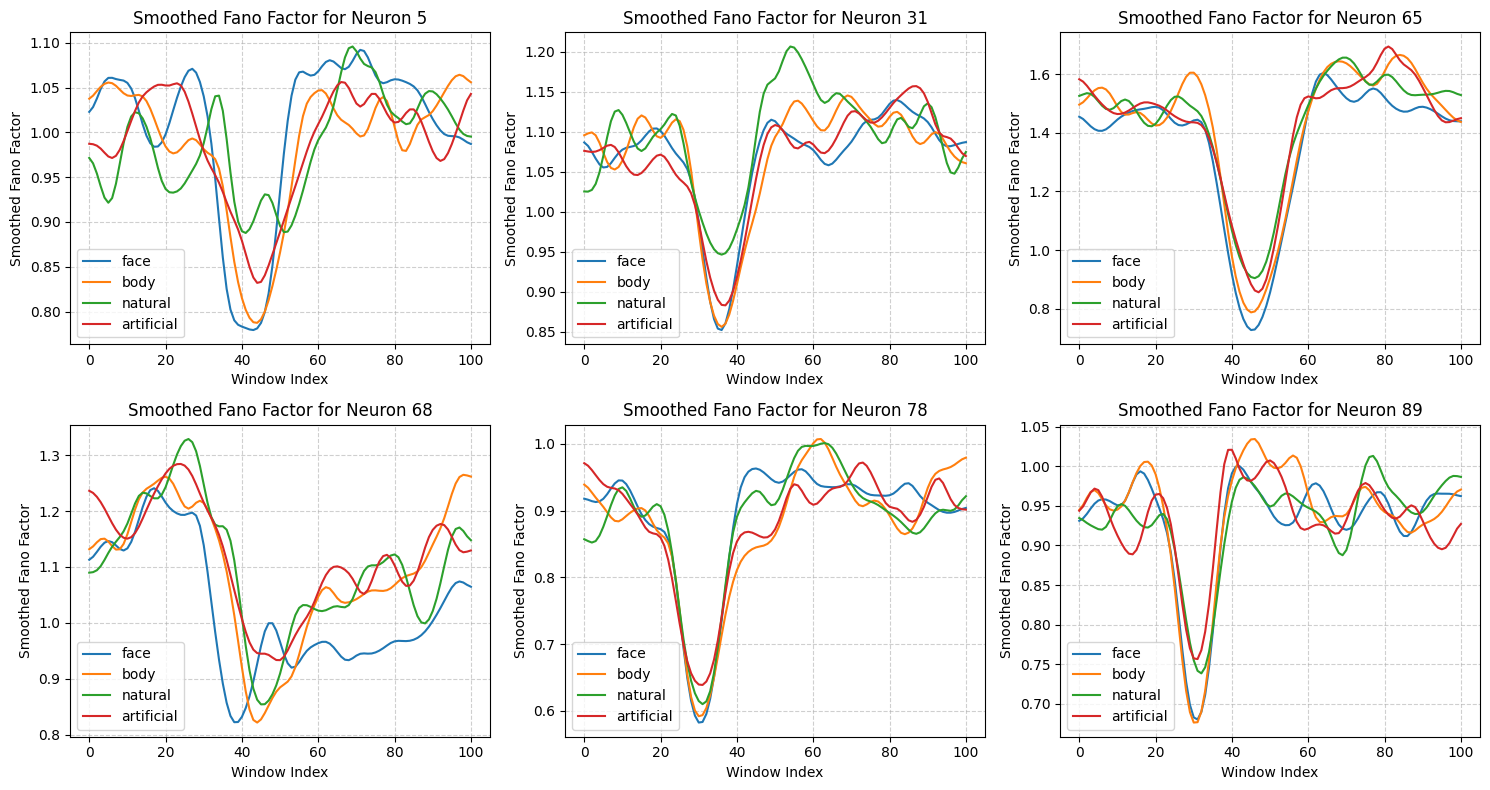

Fano Factor analysis complete. Plot saved as PDF file.

Calculating and plotting Mean-Matched Fano Factor...


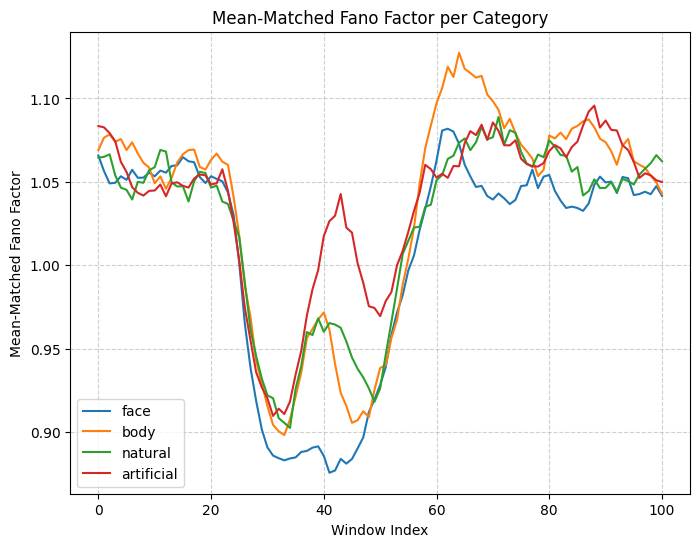

Mean-Matched Fano Factor analysis complete. Plot saved as PDF file.

Preparing data for SVM classification...
SVM data preparation complete. Shape: (500, 92, 101)

Performing single-window SVM classification...
Processing window 1/101...
  Window 1: Mean Accuracy = 21.96%, Mean Recall = [28.57142857 26.42857143 17.14285714 15.71428571]
Processing window 2/101...
  Window 2: Mean Accuracy = 24.11%, Mean Recall = [23.57142857 21.42857143 23.57142857 27.85714286]
Processing window 3/101...
  Window 3: Mean Accuracy = 26.07%, Mean Recall = [33.57142857 26.42857143 20.         24.28571429]
Processing window 4/101...
  Window 4: Mean Accuracy = 21.25%, Mean Recall = [29.28571429 22.85714286 17.14285714 15.71428571]
Processing window 5/101...
  Window 5: Mean Accuracy = 24.29%, Mean Recall = [32.85714286 25.71428571 16.42857143 22.14285714]
Processing window 6/101...
  Window 6: Mean Accuracy = 24.64%, Mean Recall = [26.42857143 26.42857143 28.57142857 17.14285714]
Processing window 7/101...


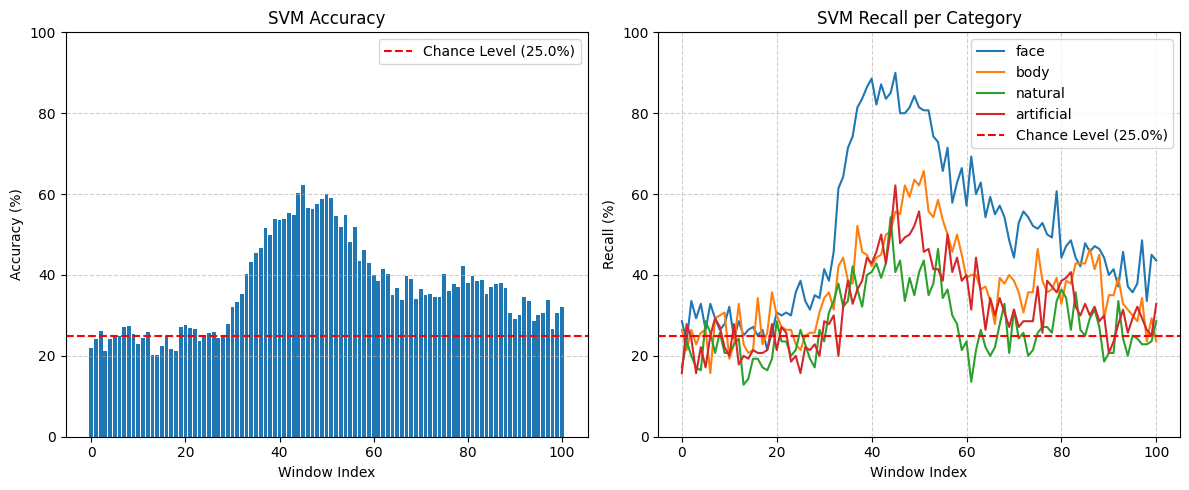


Single-window SVM classification analysis complete. Plot saved as PDF file.

Performing time-time decoding analysis...
Training on window 1/101...
Training on window 2/101...
Training on window 3/101...
Training on window 4/101...
Training on window 5/101...
Training on window 6/101...
Training on window 7/101...
Training on window 8/101...
Training on window 9/101...
Training on window 10/101...
Training on window 11/101...
Training on window 12/101...
Training on window 13/101...
Training on window 14/101...
Training on window 15/101...
Training on window 16/101...
Training on window 17/101...
Training on window 18/101...
Training on window 19/101...
Training on window 20/101...
Training on window 21/101...
Training on window 22/101...
Training on window 23/101...
Training on window 24/101...
Training on window 25/101...
Training on window 26/101...
Training on window 27/101...
Training on window 28/101...
Training on window 29/101...
Training on window 30/101...
Training on window 

/usr/local/lib/python3.11/dist-packages/matplotlib/colorbar.py:1238: RuntimeWarning: invalid value encountered in divide
  y = y / (self._boundaries[self._inside][-1] -


IndexError: index 1 is out of bounds for axis 0 with size 1

/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:2651: RuntimeWarning: divide by zero encountered in scalar divide
  y_scale = 1.0 / inh


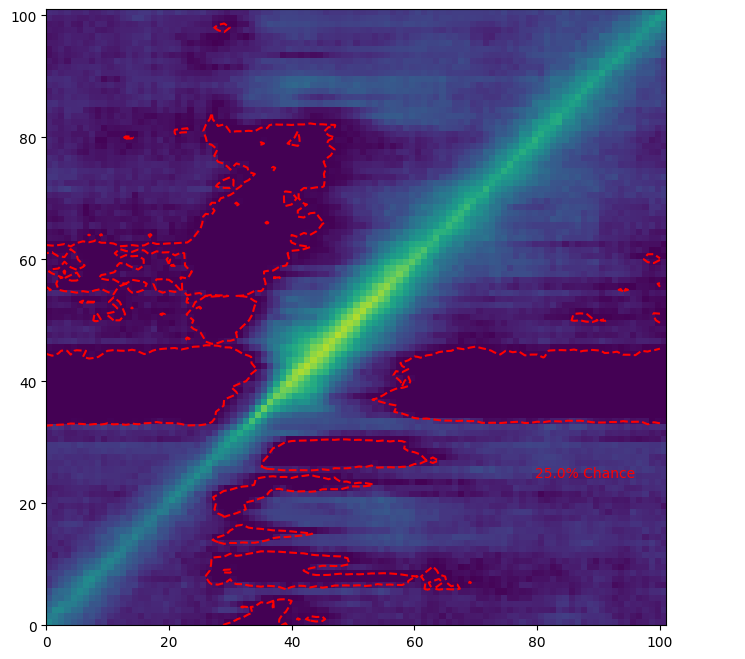

In [ ]:
try:
    with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as file:
        dataVasati = read_matlab_file(file['SpikeTrain_it_all'], file)
        data = dataVasati['data']
        cm = dataVasati['cm']
except FileNotFoundError:
    print("Error: 'dataVasati.mat' not found. Please ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the .mat file: {e}")
    exit()

data = np.vectorize(lambda arr: arr.T, otypes=[object])(data)

sampling_rate = 1000
n_neurons = data.size
time_points = data[0].shape[1]
categories = {
    "face": (1, 200),
    "body": (201, 320),
    "natural": (321, 390),
    "artificial": (391, 500)
}
n_stimuli = 500
n_classes = len(categories)
bins = [0, 200, 320, 390, 500]

trial_categories = []
for neuron in range(n_neurons):
    trial_categories.append(pd.cut(cm[neuron]['index'].flatten(), bins=bins, labels=categories.keys(), include_lowest=True).to_numpy())

trial_categories = np.array(trial_categories, dtype=object)


window_size = 50
step_size = 5
n_windows = (time_points - window_size) // step_size + 1

print(f"Number of time points: {time_points}")
print(f"Window size: {window_size} ms")
print(f"Step size: {step_size} ms")
print(f"Number of windows: {n_windows}")


print("Calculating spike counts in sliding windows...")
for n, neuron_data in enumerate(data):
    spike_counts = np.zeros((neuron_data.shape[0], n_windows))

    for i in range(n_windows):
        start = i * step_size
        end = start + window_size
        spike_counts[:, i] = np.sum(neuron_data[:, start:end], axis=1)

    data[n] = spike_counts
print("Spike count calculation complete.")



selected_neurons_fano = [5, 31, 65, 68, 78, 89]

smoothing_sigma = 2
n_cols = 3
n_rows = (len(selected_neurons_fano) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 4))

print("\nCalculating and plotting Fano Factor...")
for i, selected_neuron_id in enumerate(selected_neurons_fano):
    neuron_idx_0based = selected_neuron_id - 1

    plt.subplot(n_rows, n_cols, i + 1)

    neuron_spike_counts = data[neuron_idx_0based]
    neuron_trial_categories = trial_categories[neuron_idx_0based]

    for category in categories.keys():
        cat_trials_spike_counts = neuron_spike_counts[neuron_trial_categories == category]

        cat_fanos = []
        for w in range(n_windows):
            window_data = cat_trials_spike_counts[:, w]
            mean = np.mean(window_data)
            var = np.var(window_data)
            fano = var / mean if mean > 0 else np.nan
            cat_fanos.append(fano)

        cat_fanos = np.array(cat_fanos)

        if not np.all(np.isnan(cat_fanos)):
             valid_indices = np.where(~np.isnan(cat_fanos))[0]
             if valid_indices.size > 1:
                 smoothed_fanos = gaussian_filter1d(cat_fanos[valid_indices], sigma=smoothing_sigma)
                 plt.plot(valid_indices, smoothed_fanos, label=category)
             elif valid_indices.size == 1:
                 plt.plot(valid_indices, cat_fanos[valid_indices], 'o-', label=category)
             else:
                  plt.plot(np.arange(n_windows), np.full(n_windows, np.nan), label=category + " (No valid data)")
        else:
             plt.plot(np.arange(n_windows), cat_fanos, label=category + " (No valid data)")


    plt.title(f'Smoothed Fano Factor for Neuron {selected_neuron_id}')
    plt.xlabel('Window Index')
    plt.ylabel('Smoothed Fano Factor')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('smoothed_fano_factor.pdf', bbox_inches='tight')
plt.show()
print("Fano Factor analysis complete. Plot saved as PDF file.")



plt.figure(figsize=(8, 6))

print("\nCalculating and plotting Mean-Matched Fano Factor...")
for category in categories.keys():
    slopes = []
    for w in range(n_windows):
        means = []
        vars = []
        for neuron in range(n_neurons):
            neuron_spike_counts_window = data[neuron][trial_categories[neuron] == category, w]

            if neuron_spike_counts_window.size > 0:
                means.append(np.mean(neuron_spike_counts_window))
                vars.append(np.var(neuron_spike_counts_window))

        means = np.array(means)
        vars = np.array(vars)

        if means.size > 1 and not np.all(means == means[0]): # Need at least 2 points with different means
             reg = LinearRegression(fit_intercept=False).fit(means.reshape(-1, 1), vars)
             slopes.append(reg.coef_[0])
        else:
             slopes.append(np.nan)


    slopes = np.array(slopes)

    plt.plot(np.arange(n_windows), slopes, label=category)

plt.title('Mean-Matched Fano Factor per Category')
plt.xlabel('Window Index')
plt.ylabel('Mean-Matched Fano Factor')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()
print("Mean-Matched Fano Factor analysis complete. Plot saved as PDF file.")


print("\nPreparing data for SVM classification...")
all_windows_stim_data = np.zeros((n_stimuli, n_neurons, n_windows))

for n in range(n_neurons):
    neuron_spike_counts = data[n] # Spike counts for this neuron (trials, windows)
    neuron_trial_stim_indices = cm[n]['index'].flatten()

    stim_indices_0based = neuron_trial_stim_indices.astype(int) - 1

    for w in range(n_windows):
        neuron_spike_counts_window = neuron_spike_counts[:, w]
        sum_spike_counts_per_stim = np.bincount(stim_indices_0based, weights=neuron_spike_counts_window, minlength=n_stimuli)

        trials_per_stim = np.bincount(stim_indices_0based, minlength=n_stimuli)

        mean_spike_counts_per_stim = np.divide(sum_spike_counts_per_stim, trials_per_stim, where=trials_per_stim != 0, out=np.zeros_like(sum_spike_counts_per_stim, dtype=float))

        all_windows_stim_data[:, n, w] = mean_spike_counts_per_stim

print("SVM data preparation complete. Shape:", all_windows_stim_data.shape)

y_stim = np.zeros(n_stimuli, dtype=int)
for label, (start, end) in enumerate(categories.values()):
    y_stim[start-1:end] = label


accuracy = []
recall = []
print("\nPerforming single-window SVM classification...")
for w in range(n_windows):
    print(f"Processing window {w+1}/{n_windows}...")
    svm_data_window = all_windows_stim_data[:, :, w]

    try:
        result, _ = gen_fx_get_svm(y_stim, svm_data_window, 0.8, 10) # Adjusted rate to 0.8

        mean_accuracy_window = np.mean(result['pt']) * 100
        accuracy.append(mean_accuracy_window)

        mean_recall_window = np.mean(result['tu'], axis=0) * 100
        recall.append(mean_recall_window)

        print(f"  Window {w+1}: Mean Accuracy = {mean_accuracy_window:.2f}%, Mean Recall = {mean_recall_window}")

    except Exception as e:
        print(f"Error during SVM classification for window {w}: {e}")
        accuracy.append(np.nan)
        recall.append(np.full(n_classes, np.nan))


accuracy = np.array(accuracy)
recall = np.array(recall)
fig_width = 6
fig_height = 5
plt.figure(figsize=(2 * fig_width, fig_height))

plt.subplot(1, 2, 1)
plt.bar(range(n_windows), accuracy)
plt.ylim(0, 100)
plt.title("SVM Accuracy")
plt.xlabel("Window Index")
plt.ylabel("Accuracy (%)")
plt.axhline(100 / n_classes, color='red', linestyle='--', label=f'Chance Level ({100/n_classes:.1f}%)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.subplot(1, 2, 2)
for i, category in enumerate(categories.keys()):
    plt.plot(range(n_windows), recall[:, i], label=category)

plt.ylim(0, 100)
plt.title("SVM Recall per Category")
plt.xlabel("Window Index")
plt.ylabel("Recall (%)")
plt.axhline(100 / n_classes, color='red', linestyle='--', label=f'Chance Level ({100/n_classes:.1f}%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("\nSingle-window SVM classification analysis complete. Plot saved as PDF file.")



print("\nPerforming time-time decoding analysis...")

decoding_matrix = np.zeros((n_windows, n_windows))

for train_w in range(n_windows):
    print(f"Training on window {train_w+1}/{n_windows}...")
    X_train = all_windows_stim_data[:, :, train_w]
    y_train = y_stim
    for test_w in range(n_windows):
        X_test = all_windows_stim_data[:, :, test_w]
        y_test = y_stim
        try:
            accuracy_test, _ = gen_fx_get_svm_split(X_train, y_train, X_test, y_test)

            decoding_matrix[train_w, test_w] = accuracy_test * 100

        except Exception as e:
            print(f"Error during time-time decoding (Train W {train_w}, Test W {test_w}): {e}")
            decoding_matrix[train_w, test_w] = np.nan


print("Time-time decoding calculation complete.")


n_permutations = 1000
alpha = 0.05
print(f"\nStarting permutation testing with {n_permutations} permutations...")

print("Permutation testing placeholder complete. Implement the actual test and significance masking.")



print("\nPlotting time-time decoding matrix...")

if np.all(np.isnan(decoding_matrix)) or decoding_matrix.shape[0] < 2 or decoding_matrix.shape[1] < 2:
    print("Error: Decoding matrix is all NaNs or too small to plot.")
else:
    plt.figure(figsize=(10, 8))
    chance_level = 100 / n_classes
    plot_vmin = chance_level
    plot_vmax = 100.0
    if np.nanmax(decoding_matrix) < plot_vmin:
        plot_vmax = np.nanmax(decoding_matrix) + 1
    if np.nanmin(decoding_matrix) > plot_vmax:
         plot_vmin = np.nanmin(decoding_matrix) - 1

    plt.imshow(decoding_matrix, origin='lower', aspect='auto', cmap='viridis',
               extent=[0, n_windows, 0, n_windows], vmin=plot_vmin, vmax=plot_vmax)
    if chance_level > np.nanmin(decoding_matrix) and chance_level < np.nanmax(decoding_matrix):
        plt.contour(decoding_matrix, levels=[chance_level], colors='red', linestyles='--')
        plt.text(n_windows * 0.95, chance_level, f'{chance_level:.1f}% Chance', color='red', va='center', ha='right', fontsize=10)
    elif chance_level <= np.nanmin(decoding_matrix):
         plt.text(n_windows * 0.95, np.nanmin(decoding_matrix), f'{chance_level:.1f}% Chance (below min)', color='red', va='bottom', ha='right', fontsize=10)
    elif chance_level >= np.nanmax(decoding_matrix):
         plt.text(n_windows * 0.95, np.nanmax(decoding_matrix), f'{chance_level:.1f}% Chance (above max)', color='red', va='top', ha='right', fontsize=10)

    plt.colorbar(label='Decoding Accuracy (%)')
    plt.title('Time-Time Decoding Matrix')
    plt.xlabel('Test Window Index')
    plt.ylabel('Train Window Index')
    plt.grid(True, linestyle='--', alpha=0.6) # Add grid

    plt.show()

print("Time-time decoding plotting complete. Plot saved as PDF file.")


In [ ]:
raster_all, cm_all = load_raster_cm('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat')

<ipython-input-26-f79921b7bc6d>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm[j] = int(f[ref][()])


### SVM

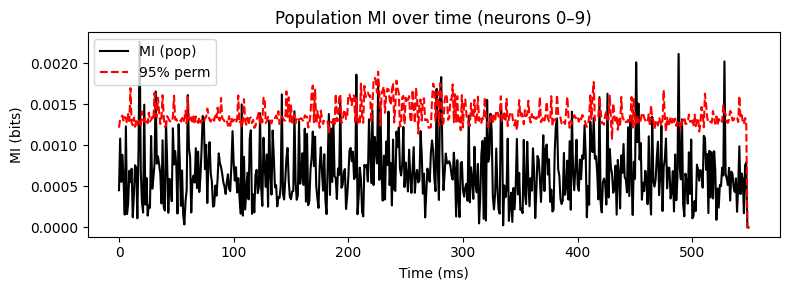

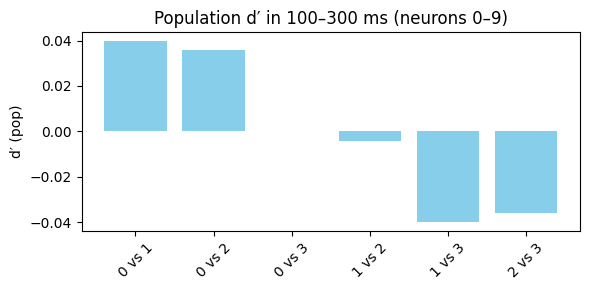

Population d-primes (neurons 0–9):
  Category 0 vs 1: d′ = 0.040
  Category 0 vs 2: d′ = 0.036
  Category 0 vs 3: d′ = 0.000
  Category 1 vs 2: d′ = -0.004
  Category 1 vs 3: d′ = -0.040
  Category 2 vs 3: d′ = -0.036


In [ ]:
from sklearn.metrics import mutual_info_score

# ---- Parameters ----
neuron_group = list(range(60,65))   # use neurons 0–9 as an example
n_time = raster_all[0].shape[1]
n_trials = raster_all[0].shape[0]

# Time window for d-prime
dp_start, dp_end = 100, 300      # ms-bins for d′
dp_slice = slice(dp_start, dp_end)

# 1) Build population spike count matrix: shape (n_trials, n_time)
#    by summing spike counts across the selected neurons at each time bin
pop_counts = np.zeros((n_trials, n_time), dtype=float)
for ni in neuron_group:
    pop_counts += raster_all[ni]

# 2) Mutual Information over time
labels = StmLabels[cm_all[0]]    # (n_trials,)

mi_ts = np.zeros(n_time)
null_thr = np.zeros(n_time)
n_perm = 500

for t in range(n_time):
    x = pop_counts[:, t]
    # discretize x into e.g. 20 bins
    bins = np.histogram_bin_edges(x, bins=20)
    x_bin = np.digitize(x, bins) - 1

    # compute observed MI
    mi_ts[t] = mutual_info_score(labels, x_bin)

    # permutation null
    mi_perm = np.zeros(n_perm)
    for k in range(n_perm):
        mi_perm[k] = mutual_info_score(np.random.permutation(labels), x_bin)
    null_thr[t] = np.percentile(mi_perm, 95)

# Plot MI
times = np.arange(n_time)
sig = mi_ts > null_thr

plt.figure(figsize=(8,3))
plt.plot(times, mi_ts, 'k', label='MI (pop)')
plt.plot(times, null_thr, 'r--', label='95% perm')
plt.fill_between(times, mi_ts, null_thr, where=sig, color='red', alpha=0.3)
plt.xlabel('Time (ms)')
plt.ylabel('MI (bits)')
plt.title('Population MI over time (neurons 0–9)')
plt.legend()
plt.tight_layout()
plt.show()

# 3) d-prime for each pair, using summed counts in [100:300] ms
pop_counts_window = pop_counts[:, dp_slice].sum(axis=1)  # (n_trials,)

# compute per-category vectors
cat_resps = {cat: pop_counts_window[labels==cat] for cat in range(4)}

from itertools import combinations

dprimes = {}
for (c1,c2) in combinations(range(4),2):
    x1 = cat_resps[c1]
    x2 = cat_resps[c2]
    mu1, mu2 = x1.mean(), x2.mean()
    s1, s2 = x1.std(), x2.std()
    d = (mu1 - mu2) / np.sqrt(0.5*(s1**2 + s2**2))
    dprimes[(c1,c2)] = d

# Bar plot of d-prime
pairs = list(dprimes.keys())
vals  = [dprimes[p] for p in pairs]
labels_pairs = [f"{p[0]} vs {p[1]}" for p in pairs]

plt.figure(figsize=(6,3))
plt.bar(range(len(vals)), vals, color='skyblue')
plt.xticks(range(len(vals)), labels_pairs, rotation=45)
plt.ylabel("d′ (pop)")
plt.title("Population d′ in 100–300 ms (neurons 0–9)")
plt.tight_layout()
plt.show()

# Print results
print("Population d-primes (neurons 0–9):")
for p,v in dprimes.items():
    print(f"  Category {p[0]} vs {p[1]}: d′ = {v:.3f}")


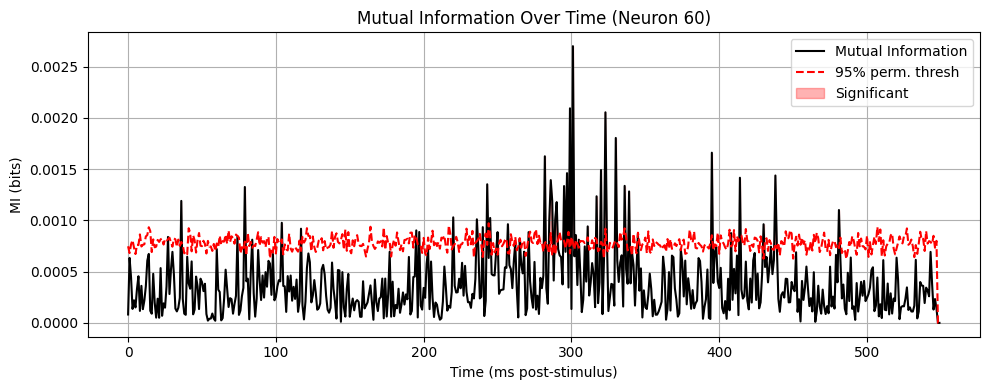

In [ ]:

trial_cats = StmLabels[pic_nums]

n_trials, n_time = raster0.shape

mi_time = np.zeros(n_time)
for t in range(n_time):
    counts_t = raster0[:, t]  # spike count per trial at time t (0 or 1)
    mi_time[t] = mutual_info_score(trial_cats, counts_t)

n_perm = 200
mi_perm = np.zeros((n_perm, n_time))

for i in range(n_perm):
    shuffled = np.random.permutation(trial_cats)
    for t in range(n_time):
        counts_t = raster0[:, t]
        mi_perm[i, t] = mutual_info_score(shuffled, counts_t)

mi_thresh = np.percentile(mi_perm, 95, axis=0)

time_ms = np.arange(n_time)  # 0…549 ms

plt.figure(figsize=(10,4))
plt.plot(time_ms, mi_time, label='Mutual Information', color='k')
plt.plot(time_ms, mi_thresh, '--', label='95% perm. thresh', color='r')
plt.fill_between(time_ms, mi_time, mi_thresh, where=(mi_time>mi_thresh),
                 color='r', alpha=0.3, label='Significant')

plt.xlabel('Time (ms post‐stimulus)')
plt.ylabel('MI (bits)')
plt.title('Mutual Information Over Time (Neuron 60)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


d′(Face vs Body) = 0.056
d′(Face vs Natural) = 0.014
d′(Face vs Artificial) = 0.092
d′(Body vs Natural) = -0.042
d′(Body vs Artificial) = 0.036
d′(Natural vs Artificial) = 0.078


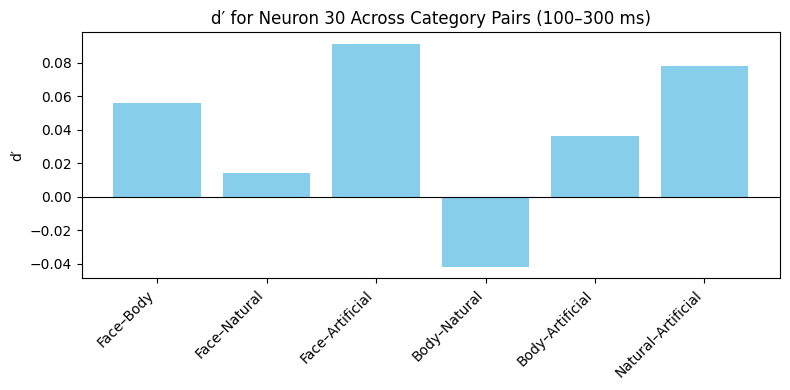

In [ ]:
start_ms, end_ms = 100, 300
counts = raster0[:, start_ms:end_ms].sum(axis=1)
trial_cats = StmLabels[pic_nums]

pairs = list(combinations(range(4), 2))
dprimes = []
labels = ['Face','Body','Natural','Artificial']

for (c1, c2) in pairs:
    x1 = counts[trial_cats == c1]
    x2 = counts[trial_cats == c2]
    mu1, mu2 = x1.mean(), x2.mean()
    s1, s2   = x1.std(ddof=1), x2.std(ddof=1)
    s_pooled = np.sqrt(0.5*(s1**2 + s2**2))
    # d-prime
    dp = (mu1 - mu2) / s_pooled if s_pooled>0 else np.nan
    dprimes.append(dp)
    print(f"d′({labels[c1]} vs {labels[c2]}) = {dp:.3f}")

x = np.arange(len(pairs))
pair_labels = [f"{labels[c1]}–{labels[c2]}" for c1,c2 in pairs]

plt.figure(figsize=(8,4))
plt.bar(x, dprimes, color='skyblue')
plt.xticks(x, pair_labels, rotation=45, ha='right')
plt.ylabel("d′")
plt.title("d′ for Neuron 30 Across Category Pairs (100–300 ms)")
plt.axhline(0, color='k', linewidth=0.8)
plt.tight_layout()
plt.show()


## Population analysis

In [ ]:
StmLabels_ordered = StmLabels[stim_ids]  # maps correctly to raster_stim second axis


Number of time points: 550
Window size: 50 ms
Step size: 5 ms
Number of windows: 101

Preparing data for RDM analysis (mean spike counts per stimulus per neuron per window)...
RDM data preparation complete. Shape: (500, 92, 101)

Computing neural RDMs over windows...
Neural RDM computation complete.

Ground-truth RDM built.

Computing Kendall's tau over windows...
Kendall's tau computation complete.


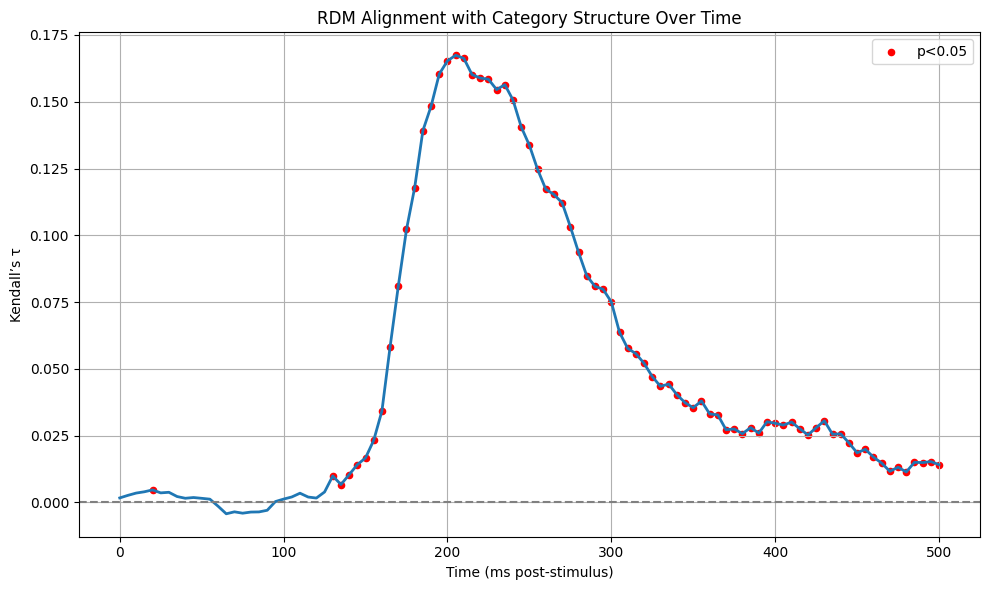


RDM analysis and plotting complete. Plot saved as PDF file.


In [ ]:
try:
    with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as file:
        dataVasati = read_matlab_file(file['SpikeTrain_it_all'], file)
        data_raw = dataVasati['data']
        cm = dataVasati['cm']
except FileNotFoundError:
    print("Error: 'dataVasati.mat' not found. Please ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the .mat file: {e}")
    exit()

data_raw = np.vectorize(lambda arr: arr.T, otypes=[object])(data_raw)

sampling_rate = 1000
n_neurons = data_raw.size
time_points = data_raw[0].shape[1]

categories = {
    "face": (1, 200),
    "body": (201, 320),
    "natural": (321, 390),
    "artificial": (391, 500)
}
n_stimuli = 500
n_classes = len(categories)

StmLabels_ordered = np.zeros(n_stimuli, dtype=int)
for label, (start, end) in enumerate(categories.values()):
    StmLabels_ordered[start-1:end] = label

window_size = 50
step_size = 5
n_windows = (time_points - window_size) // step_size + 1

print(f"Number of time points: {time_points}")
print(f"Window size: {window_size} ms")
print(f"Step size: {step_size} ms")
print(f"Number of windows: {n_windows}")

all_windows_stim_data = np.zeros((n_stimuli, n_neurons, n_windows))

print("\nPreparing data for RDM analysis (mean spike counts per stimulus per neuron per window)...")
for n in range(n_neurons):
    neuron_data_raw = data_raw[n]
    neuron_trial_stim_indices = cm[n]['index'].flatten()
    stim_indices_0based = neuron_trial_stim_indices.astype(int) - 1
    for w in range(n_windows):
        start = w * step_size
        end = start + window_size
        neuron_spike_data_window = neuron_data_raw[:, start:end]
        spike_counts_window = np.sum(neuron_spike_data_window, axis=1)
        sum_spike_counts_per_stim = np.bincount(stim_indices_0based, weights=spike_counts_window, minlength=n_stimuli)
        trials_per_stim = np.bincount(stim_indices_0based, minlength=n_stimuli)
        mean_spike_counts_per_stim = np.divide(sum_spike_counts_per_stim, trials_per_stim, where=trials_per_stim != 0, out=np.zeros_like(sum_spike_counts_per_stim, dtype=float))
        all_windows_stim_data[:, n, w] = mean_spike_counts_per_stim

print("RDM data preparation complete. Shape:", all_windows_stim_data.shape)

RDM_neural = np.zeros((n_stimuli, n_stimuli, n_windows))

print("\nComputing neural RDMs over windows...")
for w in range(n_windows):
    X_window = all_windows_stim_data[:, :, w]
    if X_window.shape[0] < 2 or X_window.shape[1] < 2 or np.all(X_window.std(axis=0) < 1e-12):
        print(f"Warning: Insufficient data for RDM calculation in window {w}. Filling with NaNs.")
        RDM_neural[:, :, w] = np.nan
        continue
    std_dev = X_window.std(axis=0) + 1e-12
    X_normalized = (X_window - X_window.mean(axis=0)) / std_dev
    corr = np.corrcoef(X_normalized)
    corr[np.isnan(corr)] = 0
    corr[np.isinf(corr)] = 0
    corr = np.clip(corr, -1, 1)
    RDM_neural[:, :, w] = 1.0 - corr

print("Neural RDM computation complete.")

RDM_truth = np.zeros((n_stimuli, n_stimuli))
for i in range(n_stimuli):
    for j in range(n_stimuli):
        RDM_truth[i, j] = 0 if StmLabels_ordered[i] == StmLabels_ordered[j] else 1

print("\nGround-truth RDM built.")

triu_idx = np.triu_indices(n_stimuli, k=1)
truth_vec = RDM_truth[triu_idx]

tau_time = np.zeros(n_windows)
pval_time = np.zeros(n_windows)

print("\nComputing Kendall's tau over windows...")
for w in range(n_windows):
    neu_vec = RDM_neural[:, :, w][triu_idx]
    if np.any(np.isnan(neu_vec)):
        print(f"Warning: NaNs found in neural RDM vector for window {w}. Kendall's tau will be NaN.")
        tau_time[w] = np.nan
        pval_time[w] = np.nan
        continue
    try:
        tau, p = kendalltau(truth_vec, neu_vec)
        tau_time[w] = tau
        pval_time[w] = p
    except ValueError as e:
        print(f"Warning: Could not compute Kendall's tau for window {w} due to ValueError: {e}. Data might be constant or contain issues.")
        tau_time[w] = np.nan
        pval_time[w] = np.nan
    except Exception as e:
        print(f"An unexpected error occurred during Kendall's tau calculation for window {w}: {e}")
        tau_time[w] = np.nan
        pval_time[w] = np.nan

print("Kendall's tau computation complete.")

window_times = np.arange(n_windows) * step_size

plt.figure(figsize=(10,6))
plt.plot(window_times, tau_time, linewidth=2)
plt.axhline(0, color='gray', linestyle='--')
if not np.all(np.isnan(pval_time)):
    sig_windows = np.where(pval_time < 0.05)[0]
    plt.scatter(window_times[sig_windows], tau_time[sig_window], color='red', s=20, label='p<0.05')
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel("Kendall’s τ")
plt.title('RDM Alignment with Category Structure Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('rdm_kendall_tau.pdf', bbox_inches='tight')
plt.show()

print("\nRDM analysis and plotting complete. Plot saved as PDF file.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_category_rdm_barplot(RDM, StmLabels_full, tau_time):
    # --- 1. Find peak tau time ---
    peak_slice = np.nanargmax(tau_time)  # index of peak Kendall tau
    print(f"Peak Kendall tau at time slice {peak_slice} with value {tau_time[peak_slice]:.3f}")

    # --- 2. Extract RDM at that time ---
    rdm_at_peak = RDM[:, :, peak_slice]  # shape (500, 500)

    # --- 3. Initialize 4x4 category matrix ---
    cat_labels = ['Face', 'Body', 'Natural', 'Artificial']
    n_cat = 4
    rdm_cat = np.zeros((n_cat, n_cat))

    for i in range(n_cat):
        idx_i = np.where(StmLabels_full == i)[0]
        for j in range(n_cat):
            idx_j = np.where(StmLabels_full == j)[0]
            sub_rdm = rdm_at_peak[np.ix_(idx_i, idx_j)]
            rdm_cat[i, j] = np.nanmean(sub_rdm)

    # --- 4. Plot heatmap and barplot ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Heatmap
    im = ax[0].imshow(rdm_cat, cmap='viridis', vmin=0, vmax=1)
    ax[0].set_xticks(np.arange(n_cat))
    ax[0].set_yticks(np.arange(n_cat))
    ax[0].set_xticklabels(cat_labels)
    ax[0].set_yticklabels(cat_labels)
    ax[0].set_title('Neural Category RDM (mean dissimilarity)')
    plt.colorbar(im, ax=ax[0])

    # Barplot of off-diagonal dissimilarities
    bars = []
    labels = []
    for i in range(n_cat):
        for j in range(i + 1, n_cat):
            bars.append(rdm_cat[i, j])
            labels.append(f'{cat_labels[i]} vs {cat_labels[j]}')

    ax[1].bar(labels, bars, color='steelblue')
    ax[1].set_ylabel('Mean dissimilarity (1 - corr)')
    ax[1].set_title('Mean Neural Dissimilarity Between Categories')
    ax[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.ndimage import gaussian_filter1d

def two_category_rdm_kendall(RDM, StmLabels_full, cat_a=0, cat_b=1, sigma=2):
    """
    Restrict RDM to two categories and compute smoothed Kendall’s tau over time.

    Parameters:
    - RDM: (n_stimuli, n_stimuli, n_slices)
    - StmLabels_full: (n_stimuli,) array with labels 0–3
    - cat_a, cat_b: category IDs to compare
    - sigma: smoothing kernel width for Gaussian filter

    Returns:
    - tau_time: unsmoothed Kendall’s τ values
    - tau_smooth: smoothed τ values for plotting
    """
    selected_idx = np.where((StmLabels_full == cat_a) | (StmLabels_full == cat_b))[0]
    labels_2cat = StmLabels_full[selected_idx]
    n = len(selected_idx)
    print(f"Selected {n} stimuli: {np.sum(labels_2cat == cat_a)} in Cat {cat_a}, {np.sum(labels_2cat == cat_b)} in Cat {cat_b}")

    # Ground truth RDM (0 = same class, 1 = different)
    GT_rdm = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            GT_rdm[i, j] = int(labels_2cat[i] != labels_2cat[j])

    triu_idx = np.triu_indices(n, k=1)
    gt_vec = GT_rdm[triu_idx]

    n_slices = RDM.shape[2]
    tau_time = np.zeros(n_slices)

    for t in range(n_slices):
        rdm_slice = RDM[np.ix_(selected_idx, selected_idx, [t])][:, :, 0]
        rdm_vec = rdm_slice[triu_idx]
        tau, _ = kendalltau(rdm_vec, gt_vec)
        tau_time[t] = tau if not np.isnan(tau) else 0

    # Apply Gaussian smoothing
    tau_smooth = gaussian_filter1d(tau_time, sigma=sigma)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(tau_time, color='gray', alpha=0.3, label='Raw Kendall’s τ')
    plt.plot(tau_smooth, color='black', linewidth=2, label='Smoothed Kendall’s τ')
    plt.xlabel('Time slice')
    plt.ylabel("Kendall’s τ")
    plt.title(f"Smoothed Kendall’s τ (Cat {cat_a} vs {cat_b})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return tau_time, tau_smooth


In [ ]:

data = np.stack(raster_all, axis=1)

pic_nums = cm_all[0]

In [ ]:
StmLabels = np.zeros(pic_nums.max()+1, dtype=int)
StmLabels[1:201]   = 0  # Face
StmLabels[201:321] = 1  # Body
StmLabels[321:391] = 2  # Natural
StmLabels[391:501] = 3  # Artificial

trial_cats = StmLabels[pic_nums]

In [ ]:

gt_rdm = np.ones((4,4)) - np.eye(4)
gt_vec = squareform(gt_rdm, checks=False)


### GLM


Creating placeholder Visual Feature RDM...
Placeholder Visual Feature RDM created.

Performing GLM analysis for each window...
GLM analysis complete.


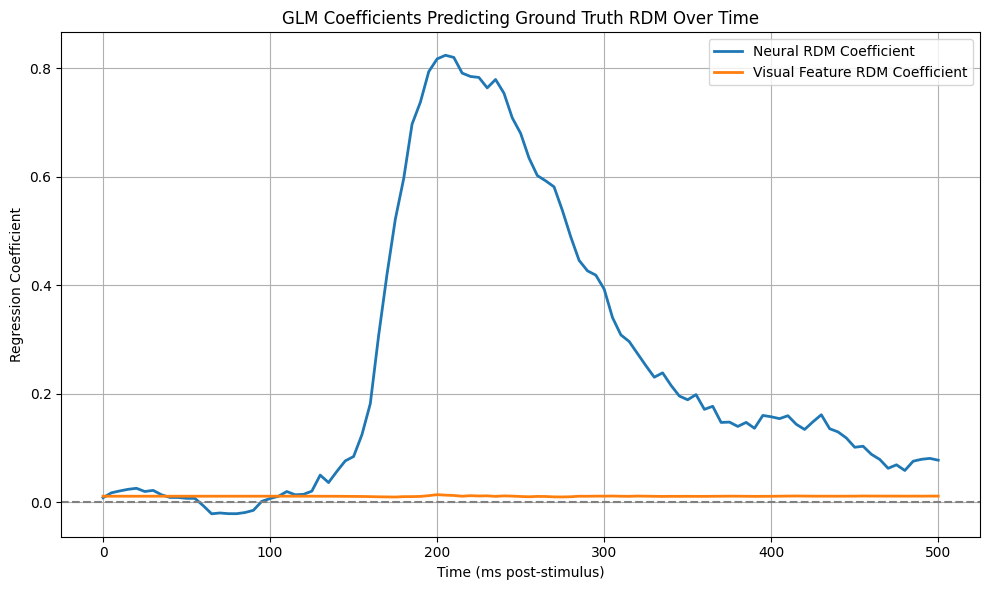

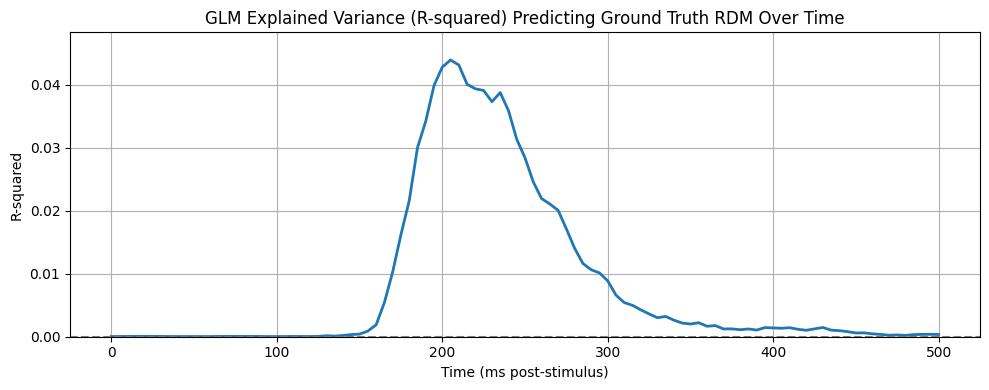


GLM analysis and plotting complete. Plots saved as PDF files.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.io import savemat

try:
    RDM_neural.shape
    RDM_truth.shape
    n_stimuli, _, n_windows = RDM_neural.shape
except NameError:
    print("RDM_neural or RDM_truth not found. Creating dummy data for demonstration.")
    n_stimuli = 500
    n_windows = 101
    RDM_neural = np.random.rand(n_stimuli, n_stimuli, n_windows)
    for w in range(n_windows):
        RDM_neural[:, :, w] = (RDM_neural[:, :, w] + RDM_neural[:, :, w].T) / 2
        np.fill_diagonal(RDM_neural[:, :, w], 0)
    RDM_truth = np.random.randint(0, 2, size=(n_stimuli, n_stimuli))
    RDM_truth = (RDM_truth + RDM_truth.T) / 2
    np.fill_diagonal(RDM_truth, 0)

print("\nCreating placeholder Visual Feature RDM...")
RDM_visual_feature = np.random.rand(n_stimuli, n_stimuli)
RDM_visual_feature = (RDM_visual_feature + RDM_visual_feature.T) / 2
np.fill_diagonal(RDM_visual_feature, 0)

print("Placeholder Visual Feature RDM created.")

triu_idx = np.triu_indices(n_stimuli, k=1)
truth_vec = RDM_truth[triu_idx]
visual_feature_vec = RDM_visual_feature[triu_idx]

coeff_neural_over_time = np.zeros(n_windows)
coeff_visual_over_time = np.zeros(n_windows)
r_squared_over_time = np.zeros(n_windows)

print("\nPerforming GLM analysis for each window...")
for w in range(n_windows):
    neural_vec_window = RDM_neural[:, :, w][triu_idx]
    X = np.column_stack((neural_vec_window, visual_feature_vec))
    y = truth_vec
    valid_rows_mask = ~np.isnan(X[:, 0])
    X_valid = X[valid_rows_mask]
    y_valid = y[valid_rows_mask]
    if X_valid.shape[0] < 2:
        print(f"Warning: Not enough valid data points to fit GLM in window {w}. Filling with NaNs.")
        coeff_neural_over_time[w] = np.nan
        coeff_visual_over_time[w] = np.nan
        r_squared_over_time[w] = np.nan
        continue
    model = LinearRegression()
    model.fit(X_valid, y_valid)
    coeff_neural_over_time[w] = model.coef_[0]
    coeff_visual_over_time[w] = model.coef_[1]
    r_squared_over_time[w] = model.score(X_valid, y_valid)

print("GLM analysis complete.")

window_times = np.arange(n_windows) * step_size

plt.figure(figsize=(10, 6))
plt.plot(window_times, coeff_neural_over_time, label='Neural RDM Coefficient', linewidth=2)
plt.plot(window_times, coeff_visual_over_time, label='Visual Feature RDM Coefficient', linewidth=2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('Regression Coefficient')
plt.title('GLM Coefficients Predicting Ground Truth RDM Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('glm_coefficients_over_time.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(window_times, r_squared_over_time, linewidth=2)
plt.axhline(0, color='gray', linestyle='--')
plt.ylim(min(0, np.nanmin(r_squared_over_time)), np.nanmax(r_squared_over_time) * 1.1 if np.nanmax(r_squared_over_time) > 0 else 0.1)
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('R-squared')
plt.title('GLM Explained Variance (R-squared) Predicting Ground Truth RDM Over Time')
plt.grid(True)
plt.tight_layout()
plt.savefig('glm_rsquared_over_time.pdf', bbox_inches='tight')
plt.show()

print("\nGLM analysis and plotting complete. Plots saved as PDF files.")

In [ ]:
for i in range(5):
    data_cat = lfp_trials[grp == i]
    print(f"Category {i} mean signal:", data_cat.mean())
    print(f"Category {i} std dev:", data_cat.std())


Category 0 mean signal: 0.002060909090909091
Category 0 std dev: 0.04535043268402297
Category 1 mean signal: 0.0018378787878787879
Category 1 std dev: 0.0428310750441762
Category 2 mean signal: 0.002007792207792208
Category 2 std dev: 0.044763388815443096
Category 3 mean signal: 0.001778512396694215
Category 3 std dev: 0.04213489397576574
Category 4 mean signal: nan
Category 4 std dev: nan


<ipython-input-83-9d5a9b714f94>:3: RuntimeWarning: Mean of empty slice.
  print(f"Category {i} mean signal:", data_cat.mean())
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Phase Amplitude Coupling object defined
INFO:tensorpac:Phase Amplitude Coupling object defined
    extract phases (n_pha=8) and amplitudes (n_amps=14)
INFO:tensorpac:    extract phases (n_pha=8) and amplitudes (n_amps=14)
    true PAC estimation using Mean Vector Length (MVL, Canolty et al. 2006)
INFO:tensorpac:    true PAC estimation using Mean Vector Length (MVL, Canolty et al. 2006)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=874)
INFO:tensorpac:    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=874)
    infer p-values at (p=0.05, mcp=maxstat)
INFO:tensorpac:    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)
INFO:tensorpac:    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)
    extract phas

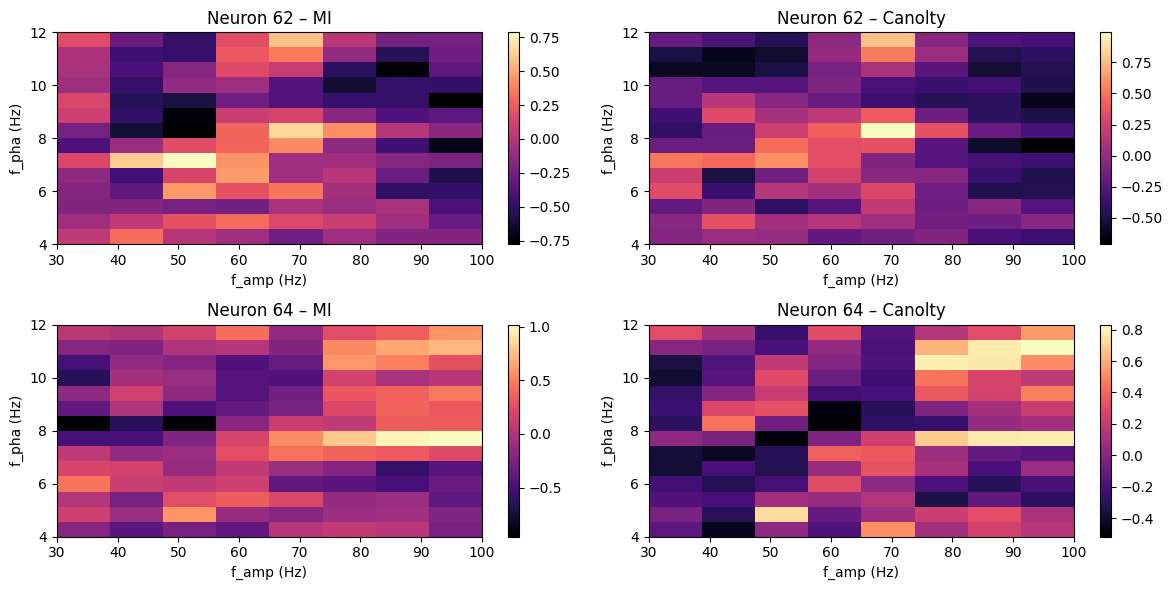

/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 1000 is greater than input length  = 822, using nperseg = 822
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


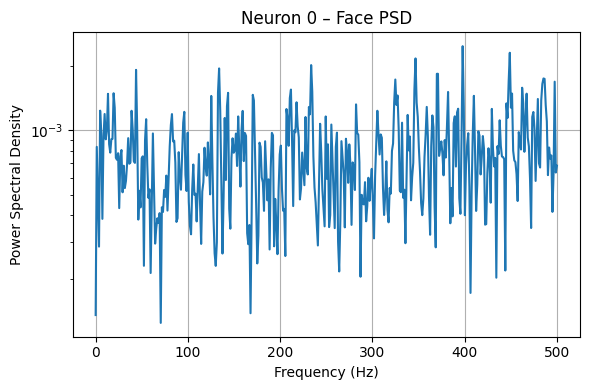

In [ ]:
def load_lfp_and_cm_lists(mat_path):
    with h5py.File(mat_path, 'r') as f:
        grp       = f['data_LFP_it']
        data_refs = grp['data_it']
        cm_refs   = grp['cm']
        lfps, cms = [], []
        for i in range(data_refs.shape[0]):
            raw = np.array(f[data_refs[i,0]])
            stim = np.array(f[cm_refs[i,0]]).flatten().astype(int)
            if raw.shape[0] == stim.shape[0]:
                lfp = raw
            elif raw.shape[1] == stim.shape[0]:
                lfp = raw.T
            else:
                n = min(raw.shape[0], stim.shape[0])
                lfp  = raw[:n, :]
                stim = stim[:n]
            lfps.append(lfp)
            cms.append(stim)
    return lfps, cms

lfp_path = '/content/drive/MyDrive/Cognitive_HW2/data_LFP.mat'
lfp_list, cm_list = load_lfp_and_cm_lists(lfp_path)
sf = 1000

n_trials = len(lfp_list[0])
trial_cat = np.full(n_trials, -1, dtype=int)
face_ids       = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/face_labels.txt', dtype=int)
body_ids       = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/body_labels.txt', dtype=int)
natural_ids    = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/natural_labels.txt', dtype=int)
artificial_ids = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/artifact_labels.txt', dtype=int)
trial_cat[face_ids]       = 0
trial_cat[body_ids]       = 1
trial_cat[natural_ids]    = 2
trial_cat[artificial_ids] = 3

f_pha  = np.arange(4, 13, 1)
f_amp  = np.arange(30, 101, 5)
methods = {'MI': (1,2,4), 'Canolty': (2,2,4)}
neurons = [62, 64]

fig, axes = plt.subplots(len(neurons), len(methods), figsize=(12,6))
for ni, neuron in enumerate(neurons):
    data = lfp_list[neuron]
    for mi, (name, idpac) in enumerate(methods.items()):
        p = Pac(idpac=idpac, f_pha=f_pha, f_amp=f_amp, dcomplex='hilbert')
        pac_by_cat = []
        for cat in range(4):
            idx = np.where(trial_cat == cat)[0]
            pac = p.filterfit(sf, data[idx, :])
            pac_by_cat.append(pac.mean(axis=2))
        pac_by_cat = np.array(pac_by_cat)
        ax = axes[ni, mi]
        im = ax.imshow(
            pac_by_cat[0], origin='lower', aspect='auto',
            extent=[f_amp[0], f_amp[-1], f_pha[0], f_pha[-1]],
            cmap='magma'
        )
        ax.set_title(f'Neuron {neuron} – {name}')
        ax.set_xlabel('f_amp (Hz)')
        ax.set_ylabel('f_pha (Hz)')
        fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

neuron, cat = 64, 0
data0 = lfp_list[neuron]
idx   = np.where(trial_cat == cat)[0]
psds  = [welch(data0[i], sf, nperseg=sf)[1] for i in idx]
mean_psd = np.mean(psds, axis=0)
f        = welch(data0[idx[0]], sf, nperseg=sf)[0]

plt.figure(figsize=(6,4))
plt.semilogy(f, mean_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Neuron 0 – Face PSD')
plt.grid(True)
plt.tight_layout()
plt.show()

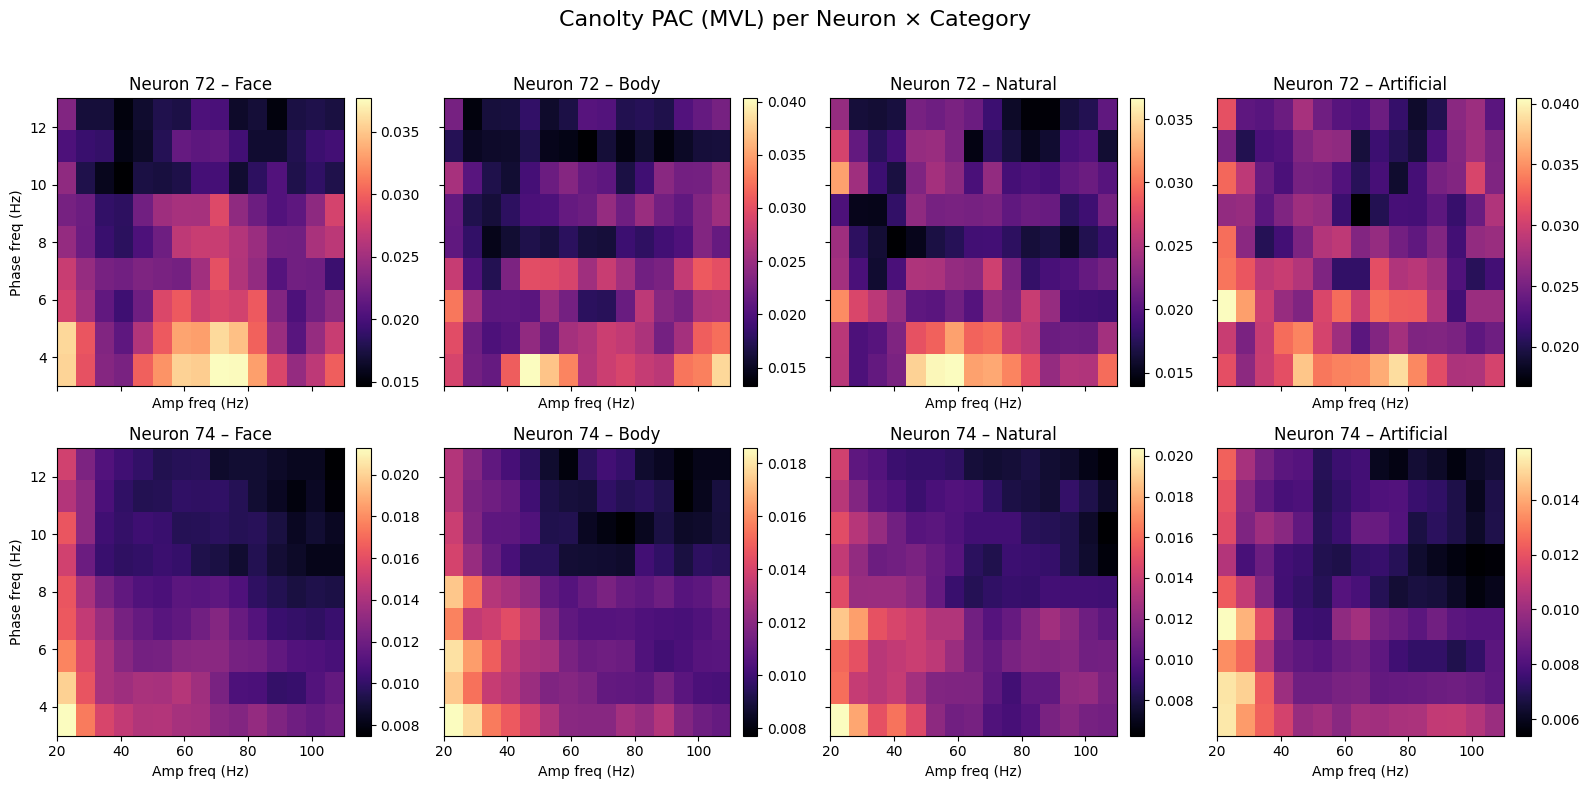

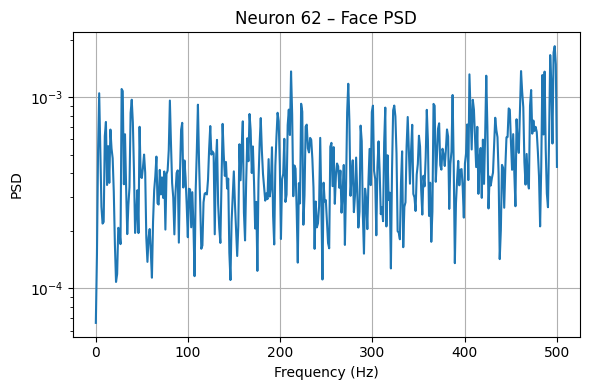

In [4]:

def bandpass(data, fs, low, high, order=4):
    nyq = fs/2
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, data, axis=-1)

def compute_pac_trial(lfp, fs, f_pha, f_amp):
    """
    lfp: 1D array (time)
    f_pha: (low, high) for phase band
    f_amp: (low, high) for amplitude band
    """
    # filter
    sig_pha = bandpass(lfp, fs, f_pha[0], f_pha[1])
    sig_amp = bandpass(lfp, fs, f_amp[0], f_amp[1])
    # hilbert
    pha = np.angle(hilbert(sig_pha))
    amp = np.abs(hilbert(sig_amp))
    # mean vector length
    return np.abs(np.mean(amp * np.exp(1j*pha)))

f_pha_centers = np.arange(4, 13, 1)
f_amp_centers = np.arange(30, 101, 5)
pha_bands = [(f-1, f+1) for f in f_pha_centers]
amp_bands = [(f-10, f+10) for f in f_amp_centers]

def load_lfp_and_categories(mat_path, label_paths):
    with h5py.File(mat_path, 'r') as f:
        grp       = f['data_LFP_it']
        data_refs = grp['data_it']
        cm_refs   = grp['cm']
        lfps, cms = [], []
        for i in range(data_refs.shape[0]):
            raw    = np.array(f[data_refs[i,0]])
            stim   = np.array(f[cm_refs[i,0]]).flatten().astype(int)
            if raw.shape[0] != stim.shape[0]:
                raw = raw.T if raw.shape[1]==stim.shape[0] else raw[:stim.shape[0],:]
            lfps.append(raw)
            cms.append(stim)
    n_trials = len(cms[0])
    cat = np.full(n_trials, -1, int)
    for c, path in enumerate(label_paths):
        idxs = np.loadtxt(path, dtype=int)
        cat[idxs] = c
    return lfps, cat

lfp_path = '/content/drive/MyDrive/Cognitive_HW2/data_LFP.mat'
label_paths = [
    '/content/drive/MyDrive/Cognitive_HW2/face_labels.txt',
    '/content/drive/MyDrive/Cognitive_HW2/body_labels.txt',
    '/content/drive/MyDrive/Cognitive_HW2/natural_labels.txt',
    '/content/drive/MyDrive/Cognitive_HW2/artifact_labels.txt',
]
lfp_list, trial_cat = load_lfp_and_categories(lfp_path, label_paths)
fs = 1000

neurons = [72, 74]
n_phi   = len(pha_bands)
n_ampi  = len(amp_bands)

fig, axes = plt.subplots(len(neurons), 4, figsize=(16,8), sharex=True, sharey=True)
category_names = ['Face','Body','Natural','Artificial']

for ni, neuron in enumerate(neurons):
    data = lfp_list[neuron]
    for cat in range(4):
        idxs = np.where(trial_cat==cat)[0]
        pac_map = np.zeros((n_phi, n_ampi))
        for i, fb in enumerate(pha_bands):
            for j, ab in enumerate(amp_bands):
                vals = [compute_pac_trial(data[t], fs, fb, ab) for t in idxs]
                pac_map[i,j] = np.mean(vals)
        ax = axes[ni,cat]
        im = ax.imshow(pac_map, origin='lower', aspect='auto',
                       extent=[amp_bands[0][0], amp_bands[-1][1],
                               pha_bands[0][0], pha_bands[-1][1]],
                       cmap='magma')
        ax.set_title(f'Neuron {neuron} – {category_names[cat]}')
        ax.set_xlabel('Amp freq (Hz)')
        if cat==0:
            ax.set_ylabel('Phase freq (Hz)')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("Canolty PAC (MVL) per Neuron × Category", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

neuron, cat = 62, 0
data0 = lfp_list[neuron]
idx0  = np.where(trial_cat==cat)[0]
psds  = [welch(data0[t], fs, nperseg=fs)[1] for t in idx0]
f     = welch(data0[idx0[0]], fs, nperseg=fs)[0]
psd_mean = np.mean(psds, axis=0)

plt.figure(figsize=(6,4))
plt.semilogy(f, psd_mean)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title(f'Neuron {neuron} – {category_names[cat]} PSD')
plt.grid(True)
plt.tight_layout()
plt.show()


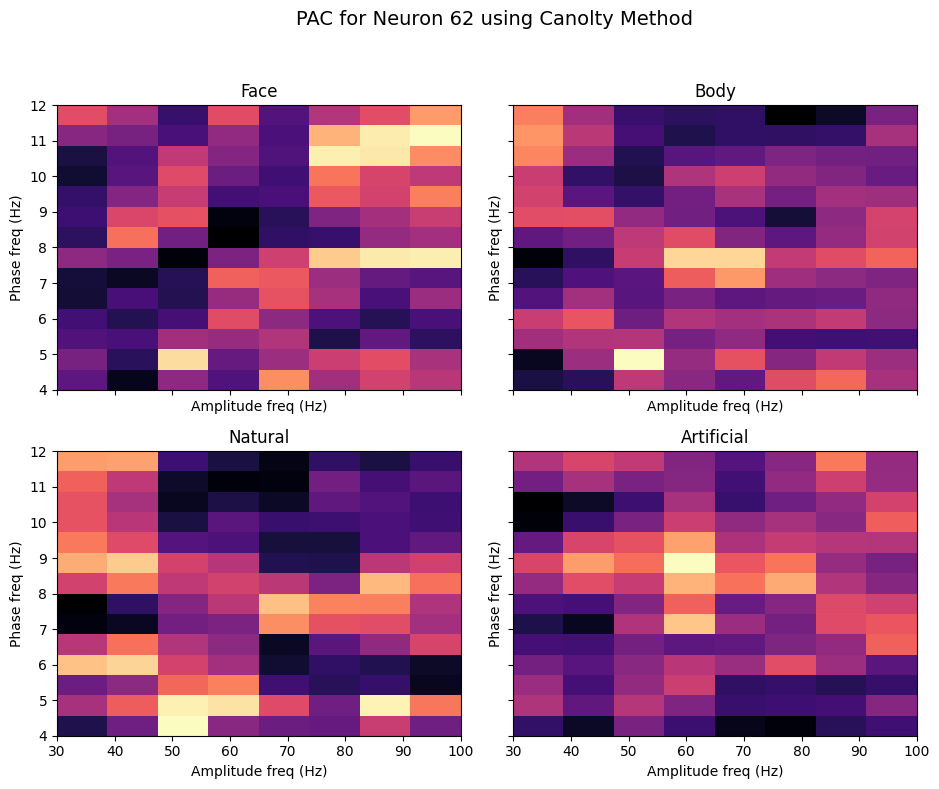

In [ ]:
names = ['Face', 'Body', 'Natural', 'Artificial']
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for cat in range(4):
    ax = axes.flat[cat]
    im = ax.imshow(pac_by_cat[cat], origin='lower', aspect='auto',
                   extent=[f_amp[0], f_amp[-1], f_pha[0], f_pha[-1]],
                   cmap='magma')
    ax.set_title(names[cat])
    ax.set_xlabel('Amplitude freq (Hz)')
    ax.set_ylabel('Phase freq (Hz)')

fig.suptitle(f"PAC for Neuron {neuron} using {name} Method", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


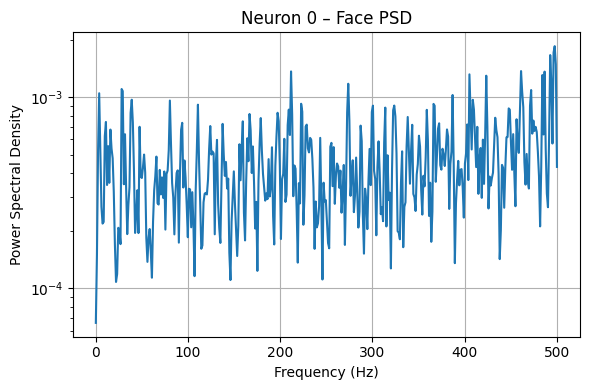

In [ ]:
neuron, cat = 62, 0
data0 = lfp_list[neuron]
idx   = np.where(trial_cat == cat)[0]
psds  = [welch(data0[i], sf, nperseg=sf)[1] for i in idx]
mean_psd = np.mean(psds, axis=0)
f        = welch(data0[idx[0]], sf, nperseg=sf)[0]

plt.figure(figsize=(6,4))
plt.semilogy(f, mean_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Neuron 0 – Face PSD')
plt.grid(True)
plt.tight_layout()
plt.show()

Phase Amplitude Coupling object defined
INFO:tensorpac:Phase Amplitude Coupling object defined
    extract phases (n_pha=8) and amplitudes (n_amps=14)
INFO:tensorpac:    extract phases (n_pha=8) and amplitudes (n_amps=14)
    true PAC estimation using Modulation Index (MI, Tort et al. 2010)
INFO:tensorpac:    true PAC estimation using Modulation Index (MI, Tort et al. 2010)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=5286)
INFO:tensorpac:    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=5286)
    infer p-values at (p=0.05, mcp=maxstat)
INFO:tensorpac:    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)
INFO:tensorpac:    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)
    extract phases (n_pha=

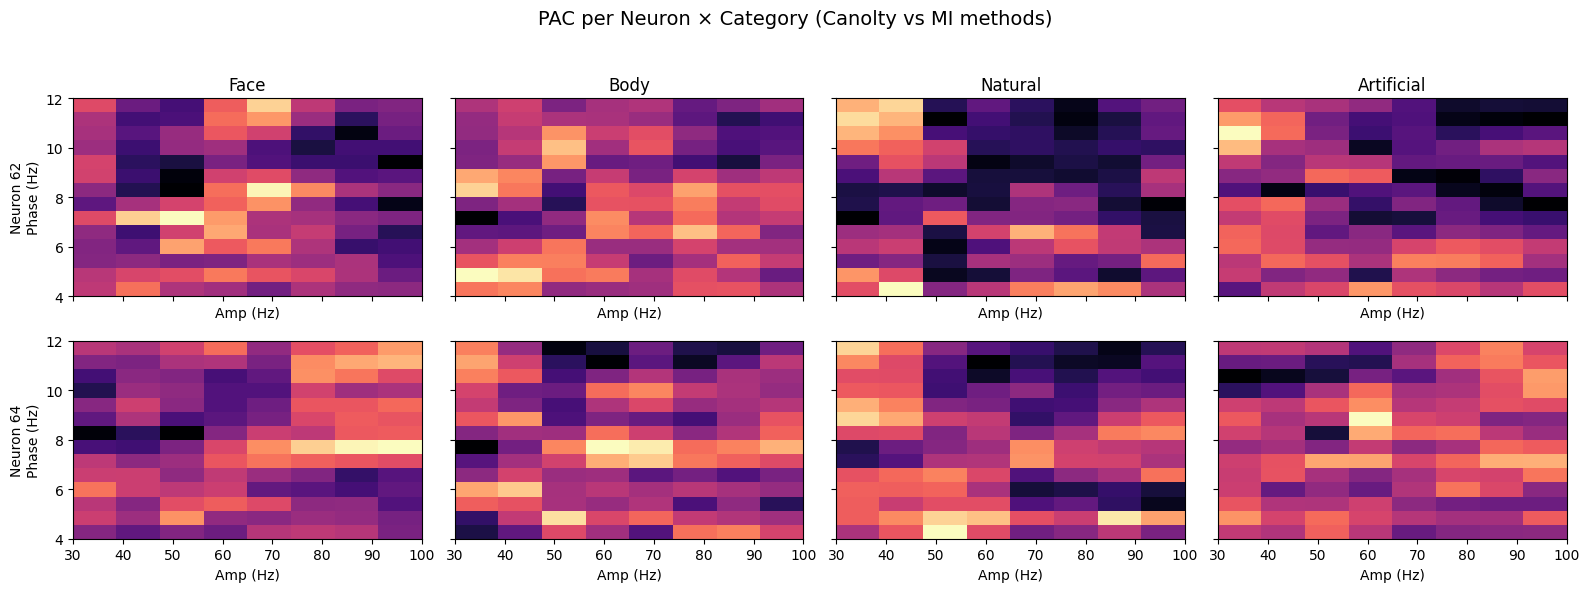

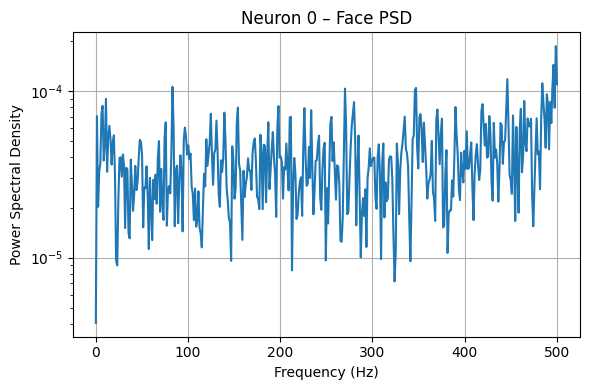

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac
from scipy.signal import welch

def load_lfp_and_cm_lists(mat_path):
    lfps, cms = [], []
    with h5py.File(mat_path, 'r') as f:
        grp       = f['data_LFP_it']
        data_refs = grp['data_it']
        cm_refs   = grp['cm']
        for i in range(data_refs.shape[0]):
            raw = np.array(f[data_refs[i,0]])
            stim = np.array(f[cm_refs[i,0]]).flatten().astype(int)
            if raw.shape[0] == stim.shape[0]:
                lfp = raw
            elif raw.shape[1] == stim.shape[0]:
                lfp = raw.T
            else:
                n = min(raw.shape[0], stim.shape[0])
                lfp  = raw[:n, :] if raw.shape[0]>=stim.shape[0] else raw[:, :n]
                stim = stim[:n]
            lfps.append(lfp)
            cms.append(stim)
    return lfps, cms

lfp_path   = '/content/drive/MyDrive/Cognitive_HW2/data_LFP.mat'
lfp_list, cm_list = load_lfp_and_cm_lists(lfp_path)
sf = 1000

trial_stim = cm_list[0]
n_trials   = len(trial_stim)
trial_cat  = np.full(n_trials, -1, dtype=int)

face_ids       = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/face_labels.txt', dtype=int)
body_ids       = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/body_labels.txt', dtype=int)
natural_ids    = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/natural_labels.txt', dtype=int)
artificial_ids = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/artifact_labels.txt', dtype=int)

trial_cat[face_ids]       = 0
trial_cat[body_ids]       = 1
trial_cat[natural_ids]    = 2
trial_cat[artificial_ids] = 3

f_pha      = np.arange(4, 13, 1)
f_amp      = np.arange(30, 101, 5)
methods    = {'Canolty': (2,2,4), 'MI': (1,2,4)}
neurons    = [62, 64]
cat_names  = ['Face','Body','Natural','Artificial']

fig, axes = plt.subplots(len(neurons), 4, figsize=(16, 6), sharex=True, sharey=True)

for ni, neuron in enumerate(neurons):
    data_n = lfp_list[neuron]
    for mi, (mname, idpac) in enumerate(methods.items()):
        p = Pac(idpac=idpac, f_pha=f_pha, f_amp=f_amp, dcomplex='hilbert')
        for cat in range(4):
            idx = np.where(trial_cat==cat)[0]
            pac_vals = p.filterfit(sf, data_n[idx, :])
            pac_mean = pac_vals.mean(axis=2)

            ax = axes[ni, cat]
            im = ax.imshow(pac_mean, origin='lower', aspect='auto',
                           extent=[f_amp[0], f_amp[-1], f_pha[0], f_pha[-1]],
                           cmap='magma')
            if ni==0:
                ax.set_title(cat_names[cat], fontsize=12)
            if cat==0:
                ax.set_ylabel(f'Neuron {neuron}\nPhase (Hz)')
            ax.set_xlabel('Amp (Hz)')

fig.suptitle("PAC per Neuron × Category (Canolty vs MI methods)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

neuron, cat = 0, 0
idx = np.where(trial_cat==cat)[0]
psd_list = []
for trial in lfp_list[neuron][idx]:
    f, Pxx = welch(trial, fs=sf, nperseg=sf)
    psd_list.append(Pxx)
psd_mean = np.mean(psd_list, axis=0)

plt.figure(figsize=(6,4))
plt.semilogy(f, psd_mean)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Neuron 0 – Face PSD')
plt.grid(True)
plt.tight_layout()
plt.show()
